# TO DO:

- habenula


# Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import matplotlib.font_manager as font_manager
from scipy.optimize import curve_fit
import math
from scipy.special import expit
from scipy import signal
import pingouin as pg

# Division / Preprocessing Functions

In [2]:
def divide_data_by_flow_direction(data):
    '''Dividing raw data from one fish into 2 dataframes with either left or right OMR flow'''
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    right = pd.DataFrame(data[data.flow_direction == 1])
    left = pd.DataFrame(data[data.flow_direction == 2])
    zero = pd.DataFrame(data[data.flow_direction == 0])

    return right, left, zero

def divide_data_by_contrast(data):
    '''Dividing raw data from one fish and one flow direction into contrast levels'''
    C_0 = pd.DataFrame(data[data.contrast_level == 0])
    C_01 = pd.DataFrame(data[data.contrast_level == 0.01])
    C_1 = pd.DataFrame(data[data.contrast_level == 0.1])
    C_2 = pd.DataFrame(data[data.contrast_level == 0.2])
    C_3 = pd.DataFrame(data[data.contrast_level == 0.3])
    C_5 = pd.DataFrame(data[data.contrast_level == 0.5])
    C_7 = pd.DataFrame(data[data.contrast_level == 0.7])
    C_10 = pd.DataFrame(data[data.contrast_level == 1])
    return C_0, C_01, C_1, C_2, C_3, C_5, C_7, C_10

def omr_preprocess(data):
    # remove timestamp and extras
    # keep x, y, heading, cumulative, timestamp
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    new = data.drop(columns = ['beat_freq', 'beat_amp','tail_move?', 'contrast_level', 'flow_direction'])
    
    # resetting index
    new = pd.DataFrame(new)
    new = new.set_index('timestamp').reset_index()


    # remove time points where there was an angle change of more than pi from one frame to another
    for i, row in new.iterrows():
        if i+1 == len(new):
            break
            # modify to add the exclusion zone
        if np.abs(new.at[i+1,'cumulative_direction']-new.at[i,'cumulative_direction']) >= 2.5:
            new.at[i+1, 'cumulative_direction'] = new.at[i,'cumulative_direction']

    tstp = np.arange(0,30,30/len(new))
    if len(new['timestamp']) != len(tstp):
        tstp = tstp[:-1]
    tstpdate = pd.to_datetime(tstp,unit='s')
    new['timestamp'] = tstp
    new['tstpdate'] = tstpdate
    new = new.set_index('tstpdate')
    new_df = new.resample('10ms')
    new_df = new_df.first()
    new_df.interpolate(method='linear',inplace=True)

    interp = new_df.copy()
    # setting first cumulative_angle to zero and ajdusting all others
    interp.iloc[:,4] -= interp.iloc[0,4]


    # calculating distance traveled between each timeframe
    # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
    interp['distance_pts'] = 0
    for row in range(1,len(interp),1):
        distance = np.sqrt((interp['X_coord'][row]-interp['X_coord'][row-1])**2\
                            +(interp['Y_coord'][row]-interp['Y_coord'][row-1])**2)
        interp.iloc[row,5] = distance


    #cleaning the timestamps
    interp.insert(0, 'new_timestamp', range(1, 1 + len(interp)))
    interp = interp.drop(columns=['timestamp']).rename(columns={'new_timestamp':'timestamp'})
    interp['timestamp'] = interp['timestamp']/100

    #resetting index to integers
    interp = interp.reset_index()
    interp = interp.drop(columns=['tstpdate'])

    return np.array(interp)

def combine_fish_data(*args):
    '''Combines preprocessed data from all fish into a 3D numpy array'''
    combined_fish = np.stack((args),axis=0)
    return combined_fish

# Reading / Preprocessing Files

In [3]:
for e in range(1,19):
    exec(f'pm_e{e} = pd.read_csv("../raw_data/PM/E2/xy_hc_fai_tstp_E2_{e}_PM.csv")')
    
for e in range(1,19):
    exec(f'pm_Re{e},pm_Le{e},pm_Ze{e} = divide_data_by_flow_direction(pm_e{e})')

for flow in ['R','L','Z']:
    for e in range(1,19):
        exec(f'pm_{flow}e{e}C_0, pm_{flow}e{e}C_1, pm_{flow}e{e}C_10, pm_{flow}e{e}C_20, pm_{flow}e{e}C_30, \
            pm_{flow}e{e}C_50, pm_{flow}e{e}C_70, pm_{flow}e{e}C_100 = divide_data_by_contrast(pm_{flow}e{e})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for e in range(1,19):
            exec(f'pm_{flow}e{e}C_{contrast} = omr_preprocess(pm_{flow}e{e}C_{contrast})')

In [4]:
for me in range(1,23):
    exec(f'pm_me{me} = pd.read_csv("../raw_data/PM/Met/xy_hc_fai_tstp_Me_{me}_PM.csv")')
    
for me in range(1,23):
    exec(f'pm_Rme{me},pm_Lme{me},pm_Zme{me} = divide_data_by_flow_direction(pm_me{me})')

for flow in ['R','L','Z']:
    for me in range(1,23):
        exec(f'pm_{flow}me{me}C_0, pm_{flow}me{me}C_1, pm_{flow}me{me}C_10, pm_{flow}me{me}C_20, pm_{flow}me{me}C_30, \
            pm_{flow}me{me}C_50, pm_{flow}me{me}C_70, pm_{flow}me{me}C_100 = divide_data_by_contrast(pm_{flow}me{me})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for me in range(1,23):
            exec(f'pm_{flow}me{me}C_{contrast} = omr_preprocess(pm_{flow}me{me}C_{contrast})')

In [5]:
for e in range(1,17):
    exec(f'am_e{e} = pd.read_csv("../raw_data/AM/E2/xy_hc_fai_tstp_E2_{e}_AM.csv")')

for e in range(1,17):
    exec(f'am_Re{e},am_Le{e},am_Ze{e} = divide_data_by_flow_direction(am_e{e})')
    
for flow in ['R','L','Z']:
    for e in range(1,17):
        exec(f'am_{flow}e{e}C_0, am_{flow}e{e}C_1, am_{flow}e{e}C_10, am_{flow}e{e}C_20, am_{flow}e{e}C_30, \
            am_{flow}e{e}C_50, am_{flow}e{e}C_70, am_{flow}e{e}C_100 = divide_data_by_contrast(am_{flow}e{e})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for e in range(1,17):
            exec(f'am_{flow}e{e}C_{contrast} = omr_preprocess(am_{flow}e{e}C_{contrast})')

In [6]:
for me in range(1,18):
    exec(f'am_me{me} = pd.read_csv("../raw_data/AM/Met/xy_hc_fai_tstp_Me_{me}_AM.csv")')
    
for me in range(1,18):
    exec(f'am_Rme{me},am_Lme{me},am_Zme{me} = divide_data_by_flow_direction(am_me{me})')

for flow in ['R','L','Z']:
    for me in range(1,18):
        exec(f'am_{flow}me{me}C_0, am_{flow}me{me}C_1, am_{flow}me{me}C_10, am_{flow}me{me}C_20, am_{flow}me{me}C_30,\
        am_{flow}me{me}C_50, am_{flow}me{me}C_70, am_{flow}me{me}C_100 = divide_data_by_contrast(am_{flow}me{me})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for me in range(1,18):
            exec(f'am_{flow}me{me}C_{contrast} = omr_preprocess(am_{flow}me{me}C_{contrast})')

# Combining Fish into 3D Arrays

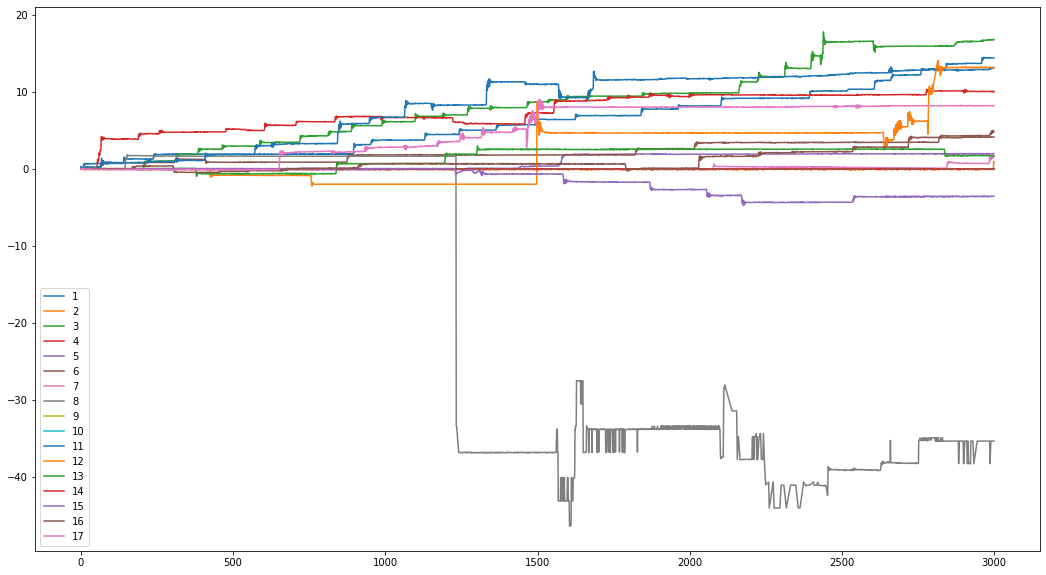

In [7]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
plt.plot(am_Lme1C_100[:,4], label='1')
plt.plot(am_Lme2C_100[:,4], label='2')
plt.plot(am_Lme3C_100[:,4], label='3')
plt.plot(am_Lme4C_100[:,4], label='4')
plt.plot(am_Lme5C_100[:,4], label='5')
plt.plot(am_Lme6C_100[:,4], label='6')
plt.plot(am_Lme7C_100[:,4], label='7')
plt.plot(am_Lme8C_100[:,4], label='8')
plt.plot(am_Lme9C_100[:,4], label='9')
plt.plot(am_Lme10C_100[:,4], label='10')
plt.plot(am_Lme11C_100[:,4], label='11')
plt.plot(am_Lme12C_100[:,4], label='12')
plt.plot(am_Lme13C_100[:,4], label='13')
plt.plot(am_Lme14C_100[:,4], label='14')
plt.plot(am_Lme15C_100[:,4], label='15')
plt.plot(am_Lme16C_100[:,4], label='16')
plt.plot(am_Lme17C_100[:,4], label='17')
# plt.plot(am_Lme18C_100[:,4], label='18')NO
# plt.plot(am_Lme19C_100[:,4], label='19')NO
# plt.plot(am_Lme20C_100[:,4], label='20')NO
# plt.plot(am_Lme21C_100[:,4], label='21')NO
# plt.plot(am_Lme22C_100[:,4], label='22')NO
plt.legend()

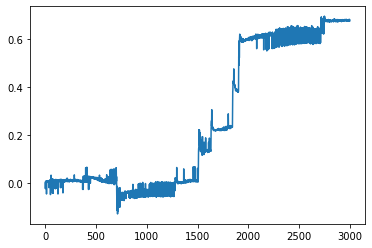

In [8]:
plt.plot(am_Re12C_10[:,4])

In [9]:
# add 3 fish 
am_comb_LeC1 = combine_fish_data(am_Le1C_1,am_Le2C_1,am_Le3C_1,am_Le4C_1,am_Le5C_1,am_Le6C_1,am_Le7C_1,am_Le8C_1,am_Le9C_1,am_Le10C_1,am_Le11C_1,\
                                am_Le12C_1,am_Le13C_1,am_Le14C_1,am_Le15C_1,am_Le16C_1)
am_comb_LeC10 = combine_fish_data(am_Le1C_10,am_Le6C_10,am_Le7C_10,am_Le8C_10,am_Le11C_10,am_Le12C_10,\
                                  am_Le14C_10,am_Le16C_10)
am_comb_LeC20 = combine_fish_data(am_Le1C_20,am_Le2C_20,am_Le3C_20,am_Le4C_20,am_Le6C_20,am_Le8C_20,am_Le9C_20,am_Le10C_20,\
                                am_Le11C_20,am_Le12C_20,am_Le13C_20,am_Le14C_20,am_Le15C_20,am_Le16C_20)
am_comb_LeC30 = combine_fish_data(am_Le1C_30,am_Le2C_30,am_Le3C_30,am_Le4C_30,am_Le5C_30,am_Le6C_30,am_Le7C_30,am_Le8C_30,am_Le9C_30,am_Le10C_30,am_Le11C_30,am_Le12C_30,\
                                am_Le13C_30,am_Le14C_30,am_Le15C_30,am_Le16C_30)
am_comb_LeC50 = combine_fish_data(am_Le1C_50,am_Le2C_50,am_Le3C_50,am_Le4C_50,am_Le6C_50,am_Le7C_50,am_Le8C_50,am_Le9C_50,\
                                am_Le12C_50,am_Le13C_50,am_Le14C_50,am_Le15C_50,am_Le16C_50)
am_comb_LeC70 = combine_fish_data(am_Le1C_70,am_Le2C_70,am_Le3C_70,am_Le4C_70,am_Le6C_70,am_Le8C_70,am_Le9C_70,am_Le10C_70,\
                                am_Le11C_70,am_Le12C_70,am_Le15C_70,am_Le16C_70)
am_comb_LeC100 = combine_fish_data(am_Le1C_100,am_Le3C_100,am_Le8C_100,am_Le9C_100,\
                                 am_Le10C_100,am_Le11C_100,am_Le14C_100,am_Le15C_100,am_Le16C_100)

am_comb_ReC1 = combine_fish_data(am_Re1C_1,am_Re2C_1,am_Re3C_1,am_Re4C_1,am_Re5C_1,am_Re6C_1,am_Re7C_1,am_Re8C_1,am_Re9C_1,am_Re10C_1,\
                                am_Re11C_1,am_Re12C_1,am_Re13C_1,am_Re14C_1,am_Re15C_1,am_Re16C_1)
am_comb_ReC10 = combine_fish_data(am_Re2C_10,am_Re3C_10,am_Re4C_10,am_Re6C_10,am_Re7C_10,am_Re8C_10,am_Re9C_10,\
                                  am_Re12C_10,am_Re13C_10,am_Re15C_10,am_Re16C_10)
am_comb_ReC20 = combine_fish_data(am_Re1C_20,am_Re2C_20,am_Re3C_20,am_Re4C_20,am_Re5C_20,am_Re6C_20,am_Re8C_20,am_Re9C_20,\
                                am_Re11C_20,am_Re12C_20,am_Re13C_20,am_Re14C_20,am_Re15C_20,am_Re16C_20)
am_comb_ReC30 = combine_fish_data(am_Re1C_30,am_Re2C_30,am_Re3C_30,am_Re4C_30,am_Re5C_30,am_Re6C_30,am_Re8C_30,am_Re9C_30,\
                                am_Re11C_30,am_Re12C_30,am_Re14C_30,am_Re15C_30,am_Re16C_30)
am_comb_ReC50 = combine_fish_data(am_Re1C_50,am_Re2C_50,am_Re3C_50,am_Re4C_50,am_Re5C_50,am_Re6C_50,am_Re7C_50,am_Re8C_50,am_Re9C_50,am_Re10C_50,\
                                am_Re11C_50,am_Re12C_50,am_Re13C_50,am_Re14C_50,am_Re15C_50,am_Re16C_50)
am_comb_ReC70 = combine_fish_data(am_Re1C_70,am_Re2C_70,am_Re3C_70,am_Re4C_70,am_Re5C_70,am_Re6C_70,am_Re7C_70,am_Re8C_70,am_Re9C_70,am_Re10C_70,\
                                am_Re11C_70,am_Re12C_70,am_Re13C_70,am_Re14C_70,am_Re15C_70,am_Re16C_70)
am_comb_ReC100 = combine_fish_data(am_Re1C_100,am_Re2C_100,am_Re3C_100,am_Re4C_100,am_Re5C_100,am_Re6C_100,am_Re7C_100,am_Re8C_100,am_Re9C_100,\
                                 am_Re10C_100,am_Re11C_100,am_Re12C_100,am_Re14C_100,am_Re15C_100,am_Re16C_100)



In [10]:
# add 3 fish
am_comb_LmeC1 = combine_fish_data(am_Lme1C_1,am_Lme2C_1,am_Lme3C_1,am_Lme4C_1,am_Lme5C_1,am_Lme6C_1,am_Lme7C_1,am_Lme8C_1,am_Lme9C_1,\
                                am_Lme10C_1,am_Lme11C_1,am_Lme12C_1,am_Lme13C_1,am_Lme14C_1,am_Lme15C_1,am_Lme16C_1,am_Lme17C_1)
am_comb_LmeC10 = combine_fish_data(am_Lme1C_10,am_Lme2C_10,am_Lme3C_10,am_Lme4C_10,am_Lme5C_10,am_Lme6C_10,am_Lme7C_10,am_Lme8C_10,am_Lme9C_10,\
                                 am_Lme10C_10,am_Lme11C_10,am_Lme12C_10,am_Lme13C_10,am_Lme14C_10,am_Lme15C_10,am_Lme16C_10,am_Lme17C_10)
am_comb_LmeC20 = combine_fish_data(am_Lme1C_20,am_Lme2C_20,am_Lme3C_20,am_Lme4C_20,am_Lme5C_20,am_Lme6C_20,am_Lme7C_20,am_Lme8C_20,am_Lme9C_20,\
                                 am_Lme10C_20,am_Lme11C_20,am_Lme12C_20,am_Lme13C_20,am_Lme14C_20,am_Lme15C_20,am_Lme16C_20)
am_comb_LmeC30 = combine_fish_data(am_Lme1C_30,am_Lme2C_30,am_Lme3C_30,am_Lme4C_30,am_Lme5C_30,am_Lme6C_30,am_Lme7C_30,am_Lme8C_30,am_Lme9C_30,\
                                 am_Lme10C_30,am_Lme11C_30,am_Lme12C_30,am_Lme13C_30,am_Lme14C_30,am_Lme15C_30,am_Lme16C_30,am_Lme17C_30)
am_comb_LmeC50 = combine_fish_data(am_Lme1C_50,am_Lme2C_50,am_Lme3C_50,am_Lme4C_50,am_Lme6C_50,am_Lme7C_50,am_Lme8C_50,am_Lme9C_50,\
                                 am_Lme10C_50,am_Lme11C_50,am_Lme13C_50,am_Lme14C_50,am_Lme15C_50,am_Lme16C_50,am_Lme17C_50)
am_comb_LmeC70 = combine_fish_data(am_Lme1C_70,am_Lme2C_70,am_Lme3C_70,am_Lme4C_70,am_Lme7C_70,am_Lme9C_70,\
                                 am_Lme10C_70,am_Lme13C_70,am_Lme14C_70,am_Lme15C_70,am_Lme16C_70,am_Lme17C_70)
am_comb_LmeC100 = combine_fish_data(am_Lme1C_100,am_Lme3C_100,am_Lme4C_100,am_Lme5C_100,am_Lme6C_100,\
                                  am_Lme11C_100,am_Lme13C_100,am_Lme15C_100,\
                                 am_Lme16C_100,am_Lme17C_100)

am_comb_RmeC1 = combine_fish_data(am_Rme1C_1,am_Rme2C_1,am_Rme3C_1,am_Rme4C_1,am_Rme5C_1,am_Rme6C_1,am_Rme7C_1,am_Rme8C_1,am_Rme9C_1,\
                                 am_Rme11C_1,am_Rme12C_1,am_Rme13C_1,am_Rme14C_1,am_Rme15C_1,am_Rme16C_1,am_Rme17C_1)
am_comb_RmeC10 = combine_fish_data(am_Rme1C_10,am_Rme2C_10,am_Rme3C_10,am_Rme4C_10,am_Rme5C_10,am_Rme6C_10,am_Rme7C_10,am_Rme8C_10,am_Rme9C_10,\
                                 am_Rme10C_10,am_Rme11C_10,am_Rme12C_10,am_Rme13C_10,am_Rme14C_10,am_Rme15C_10,am_Rme16C_10,am_Rme17C_10)
am_comb_RmeC20 = combine_fish_data(am_Rme1C_20,am_Rme2C_20,am_Rme3C_20,am_Rme4C_20,am_Rme5C_20,am_Rme6C_20,am_Rme7C_20,am_Rme8C_20,am_Rme9C_20,\
                                 am_Rme10C_20,am_Rme11C_20,am_Rme12C_20,am_Rme13C_20,am_Rme14C_20,am_Rme15C_20,am_Rme16C_20,am_Rme17C_20)
am_comb_RmeC30 = combine_fish_data(am_Rme1C_30,am_Rme2C_30,am_Rme3C_30,am_Rme4C_30,am_Rme5C_30,am_Rme6C_30,am_Rme7C_30,am_Rme8C_30,am_Rme9C_30,\
                                 am_Rme10C_30,am_Rme11C_30,am_Rme12C_30,am_Rme13C_30,am_Rme14C_30,am_Rme15C_30,am_Rme16C_30,am_Rme17C_30)
am_comb_RmeC50 = combine_fish_data(am_Rme1C_50,am_Rme2C_50,am_Rme3C_50,am_Rme4C_50,am_Rme5C_50,am_Rme6C_50,am_Rme7C_50,am_Rme8C_50,am_Rme9C_50,\
                                 am_Rme11C_50,am_Rme13C_50,am_Rme14C_50,am_Rme15C_50,am_Rme16C_50,am_Rme17C_50)
am_comb_RmeC70 = combine_fish_data(am_Rme1C_70,am_Rme2C_70,am_Rme3C_70,am_Rme4C_70,am_Rme5C_70,am_Rme6C_70,am_Rme7C_70,am_Rme8C_70,am_Rme9C_70,\
                                 am_Rme10C_70,am_Rme12C_70,am_Rme13C_70,am_Rme14C_70,am_Rme15C_70,am_Rme16C_70,am_Rme17C_70)
am_comb_RmeC100 = combine_fish_data(am_Rme1C_100,am_Rme2C_100,am_Rme3C_100,am_Rme4C_100,am_Rme5C_100,am_Rme6C_100,am_Rme7C_100,am_Rme8C_100,\
                                  am_Rme9C_100,am_Rme10C_100,am_Rme11C_100,am_Rme12C_100,am_Rme13C_100,am_Rme14C_100,am_Rme15C_100,\
                                  am_Rme16C_100,am_Rme17C_100) 



In [11]:
# add 4 fish
pm_comb_LeC1 = combine_fish_data(pm_Le1C_1,pm_Le2C_1,pm_Le3C_1,pm_Le5C_1,pm_Le6C_1,pm_Lme7C_1,pm_Le8C_1,pm_Le9C_1,\
                                 pm_Le10C_1,pm_Le11C_1,pm_Le12C_1,pm_Le13C_1,pm_Le14C_1,pm_Le15C_1,\
                                 pm_Le17C_1,pm_Le18C_1)
pm_comb_LeC10 = combine_fish_data(pm_Le1C_10,pm_Le4C_10,pm_Le6C_10,pm_Le7C_10,pm_Le8C_10,pm_Le10C_10,pm_Le12C_10,\
                                  pm_Le16C_10)
pm_comb_LeC20 = combine_fish_data(pm_Le2C_20,pm_Le3C_20,pm_Le4C_20,pm_Le5C_20,pm_Le8C_20,pm_Le10C_20,pm_Le13C_20,\
                                  pm_Le14C_20,pm_Le16C_20)
pm_comb_LeC30 = combine_fish_data(pm_Le1C_30,pm_Le2C_30,pm_Le3C_30,pm_Le4C_30,pm_Le5C_30,pm_Le6C_30,pm_Le7C_30,\
                                  pm_Le8C_30,pm_Le10C_30,pm_Le11C_30,pm_Le12C_30,pm_Le13C_30,pm_Le14C_30,pm_Le15C_30,\
                                  pm_Le17C_30,pm_Le18C_30)
pm_comb_LeC50 = combine_fish_data(pm_Le1C_50,pm_Le2C_50,pm_Le3C_50,pm_Le4C_50,pm_Le5C_50,pm_Le6C_50,pm_Le7C_50,\
                                  pm_Le8C_50,pm_Le10C_50,pm_Le11C_50,pm_Le12C_50,pm_Le13C_50,pm_Le14C_50,pm_Le16C_50,\
                                  pm_Le17C_50,pm_Le18C_50)
pm_comb_LeC70 = combine_fish_data(pm_Le1C_70,pm_Le2C_70,pm_Le3C_70,pm_Le4C_70,pm_Le5C_70,pm_Le6C_70,pm_Le7C_70,\
                                  pm_Le8C_70,pm_Le9C_70,pm_Le10C_70,pm_Le11C_70,pm_Le12C_70,pm_Le13C_70,pm_Le14C_70,\
                                  pm_Le15C_70,pm_Le16C_70,pm_Le17C_70,pm_Le18C_70)
pm_comb_LeC100 = combine_fish_data(pm_Le4C_100,pm_Le6C_100,pm_Le7C_100,pm_Le8C_100,pm_Le9C_100,pm_Le12C_100,\
                                   pm_Le14C_100,pm_Le16C_100)

pm_comb_ReC1 = combine_fish_data(pm_Re1C_1,pm_Re2C_1,pm_Re3C_1,pm_Re4C_1,pm_Re5C_1,pm_Re6C_1,pm_Re8C_1,\
                                 pm_Re10C_1,pm_Re11C_1,pm_Re12C_1,pm_Re13C_1,pm_Re14C_1,pm_Re15C_1,pm_Re16C_1,\
                                 pm_Re17C_1,pm_Re18C_1)
pm_comb_ReC10 = combine_fish_data(pm_Re1C_10,pm_Re2C_10,pm_Re3C_10,pm_Re4C_10,pm_Re5C_10,pm_Re6C_10,pm_Re7C_10,\
                                  pm_Re8C_10,pm_Re11C_10,pm_Re12C_10,pm_Re13C_10,pm_Re14C_10,pm_Re15C_10,pm_Re16C_10,\
                                  pm_Re17C_10,pm_Re18C_10)
pm_comb_ReC20 = combine_fish_data(pm_Re1C_20,pm_Re2C_20,pm_Re3C_20,pm_Re4C_20,pm_Re5C_20,pm_Re6C_20,pm_Re7C_20,\
                                  pm_Re8C_20,pm_Re9C_20,pm_Re10C_20,pm_Re11C_20,pm_Re12C_20,pm_Re13C_20,pm_Re14C_20,\
                                  pm_Re15C_20,pm_Re16C_20,pm_Re17C_20,pm_Re18C_20)
pm_comb_ReC30 = combine_fish_data(pm_Re1C_30,pm_Re2C_30,pm_Re3C_30,pm_Re4C_30,pm_Re5C_30,pm_Re6C_30,pm_Re7C_30,\
                                  pm_Re8C_30,pm_Re10C_30,pm_Re11C_30,pm_Re12C_30,pm_Re13C_30,pm_Re14C_30,pm_Re15C_30,\
                                  pm_Re16C_30,pm_Re17C_30,pm_Re18C_30)
pm_comb_ReC50 = combine_fish_data(pm_Re1C_50,pm_Re2C_50,pm_Re3C_50,pm_Re4C_50,pm_Re5C_50,pm_Re6C_50,pm_Re7C_50,\
                                  pm_Re8C_50,pm_Re9C_50,pm_Re10C_50,pm_Re11C_50,pm_Re12C_50,pm_Re13C_50,pm_Re14C_50,\
                                  pm_Re15C_50,pm_Re16C_50,pm_Re17C_50,pm_Re18C_50)
pm_comb_ReC70 = combine_fish_data(pm_Re1C_70,pm_Re2C_70,pm_Re3C_70,pm_Re4C_70,pm_Re5C_70,pm_Re6C_70,pm_Re7C_70,\
                                  pm_Re8C_70,pm_Re10C_70,pm_Re11C_70,pm_Re12C_70,pm_Re13C_70,pm_Re14C_70,pm_Re15C_70,\
                                  pm_Re16C_70,pm_Re17C_70,pm_Re18C_70)
pm_comb_ReC100 = combine_fish_data(pm_Re1C_100,pm_Re2C_100,pm_Re3C_100,pm_Re4C_100,pm_Re5C_100,pm_Re6C_100,\
                                   pm_Re7C_100,pm_Re8C_100,pm_Re9C_100,pm_Re10C_100,pm_Re13C_100,pm_Re14C_100,\
                                   pm_Re16C_100,pm_Re17C_100,pm_Re18C_100)


In [12]:
# add 5 fish
pm_comb_LmeC1 = combine_fish_data(pm_Lme1C_1,pm_Lme2C_1,pm_Lme3C_1,pm_Lme4C_1,pm_Lme5C_1,pm_Lme6C_1,pm_Lme7C_1,\
                                  pm_Lme8C_1,pm_Lme9C_1,pm_Lme10C_1,pm_Lme11C_1,pm_Lme12C_1,pm_Lme13C_1,pm_Lme14C_1,\
                                  pm_Lme15C_1,pm_Lme16C_1,pm_Lme17C_1,pm_Lme18C_1,pm_Lme19C_1,pm_Lme20C_1,\
                                  pm_Lme21C_1,pm_Lme22C_1)
pm_comb_LmeC10 = combine_fish_data(pm_Lme1C_10,pm_Lme2C_10,pm_Lme3C_10,pm_Lme4C_10,pm_Lme5C_10,pm_Lme6C_10,\
                                   pm_Lme7C_10,pm_Lme8C_10,pm_Lme9C_10,pm_Lme10C_10,pm_Lme11C_10,pm_Lme12C_10,\
                                   pm_Lme13C_10,pm_Lme14C_10,pm_Lme15C_10,pm_Lme16C_10,pm_Lme17C_10,pm_Lme18C_10,\
                                   pm_Lme20C_10,pm_Lme21C_10,pm_Lme22C_10)
pm_comb_LmeC20 = combine_fish_data(pm_Lme1C_20,pm_Lme2C_20,pm_Lme4C_20,pm_Lme7C_20,pm_Lme8C_20,\
                                   pm_Lme10C_20,pm_Lme11C_20,pm_Lme12C_20,pm_Lme15C_20,pm_Lme17C_20,\
                                   pm_Lme18C_20,pm_Lme21C_20,pm_Lme22C_20)
pm_comb_LmeC30 = combine_fish_data(pm_Lme1C_30,pm_Lme2C_30,pm_Lme4C_30,pm_Lme5C_30,\
                                   pm_Lme7C_30,pm_Lme8C_30,pm_Lme9C_30,pm_Lme10C_30,pm_Lme11C_30,pm_Lme12C_30,\
                                   pm_Lme14C_30,pm_Lme15C_30,pm_Lme16C_30,pm_Lme17C_30,pm_Lme18C_30,\
                                   pm_Lme19C_30,pm_Lme20C_30,pm_Lme21C_30)
pm_comb_LmeC50 = combine_fish_data(pm_Lme1C_50,pm_Lme2C_50,pm_Lme3C_50,pm_Lme4C_50,pm_Lme5C_50,pm_Lme6C_50,\
                                   pm_Lme7C_50,pm_Lme8C_50,pm_Lme9C_50,pm_Lme10C_50,pm_Lme11C_50,pm_Lme12C_50,\
                                   pm_Lme13C_50,pm_Lme14C_50,pm_Lme15C_50,pm_Lme16C_50,pm_Lme17C_50,pm_Lme18C_50,\
                                   pm_Lme19C_50,pm_Lme20C_50,pm_Lme21C_50,pm_Lme22C_50)
pm_comb_LmeC70 = combine_fish_data(pm_Lme1C_70,pm_Lme2C_70,pm_Lme3C_70,pm_Lme4C_70,pm_Lme5C_70,pm_Lme6C_70,\
                                   pm_Lme7C_70,pm_Lme8C_70,pm_Lme9C_70,pm_Lme10C_70,pm_Lme11C_70,pm_Lme12C_70,\
                                   pm_Lme13C_70,pm_Lme14C_70,pm_Lme15C_70,pm_Lme16C_70,pm_Lme17C_70,pm_Lme18C_70,\
                                   pm_Lme19C_70,pm_Lme20C_70,pm_Lme21C_70,pm_Lme22C_70)
pm_comb_LmeC100 = combine_fish_data(pm_Lme1C_100,pm_Lme2C_100,pm_Lme3C_100,pm_Lme4C_100,pm_Lme5C_100,pm_Lme6C_100,\
                                    pm_Lme7C_100,pm_Lme8C_100,pm_Lme9C_100,pm_Lme10C_100,pm_Lme11C_100,pm_Lme12C_100,\
                                    pm_Lme13C_100,pm_Lme14C_100,pm_Lme15C_100,pm_Lme16C_100,pm_Lme17C_100,\
                                    pm_Lme18C_100,pm_Lme19C_100,pm_Lme20C_100,pm_Lme21C_100,pm_Lme22C_100)

pm_comb_RmeC1 = combine_fish_data(pm_Rme1C_1,pm_Rme2C_1,pm_Rme3C_1,pm_Rme4C_1,pm_Rme5C_1,pm_Rme6C_1,pm_Rme7C_1,\
                                  pm_Rme8C_1,pm_Rme9C_1,pm_Rme10C_1,pm_Rme11C_1,pm_Rme12C_1,pm_Rme13C_1,pm_Rme14C_1,\
                                  pm_Rme15C_1,pm_Rme16C_1,pm_Rme17C_1,pm_Rme18C_1,pm_Rme19C_1,pm_Rme20C_1,\
                                  pm_Rme21C_1,pm_Rme22C_1)
pm_comb_RmeC10 = combine_fish_data(pm_Rme1C_10,pm_Rme2C_10,pm_Rme3C_10,pm_Rme4C_10,pm_Rme5C_10,pm_Rme6C_10,\
                                   pm_Rme7C_10,pm_Rme8C_10,pm_Rme9C_10,pm_Rme10C_10,pm_Rme11C_10,pm_Rme12C_10,\
                                   pm_Rme13C_10,pm_Rme14C_10,pm_Rme15C_10,pm_Rme17C_10,pm_Rme18C_10,pm_Rme19C_10,\
                                   pm_Rme20C_10,pm_Rme21C_10,pm_Rme22C_10)
pm_comb_RmeC20 = combine_fish_data(pm_Rme1C_20,pm_Rme2C_20,pm_Rme3C_20,pm_Rme4C_20,pm_Rme5C_20,pm_Rme6C_20,\
                                   pm_Rme7C_20,pm_Rme8C_20,pm_Rme9C_20,pm_Rme10C_20,pm_Rme11C_20,pm_Rme15C_20,\
                                   pm_Rme16C_20,pm_Rme17C_20,pm_Rme21C_20,pm_Rme22C_20)
pm_comb_RmeC30 = combine_fish_data(pm_Rme1C_30,pm_Rme2C_30,pm_Rme4C_30,pm_Rme5C_30,pm_Rme7C_30,pm_Rme12C_30,\
                                   pm_Rme14C_30,pm_Rme17C_30,pm_Rme18C_30,pm_Rme19C_30,pm_Rme21C_30)
pm_comb_RmeC50 = combine_fish_data(pm_Rme1C_50,pm_Rme2C_50,pm_Rme3C_50,pm_Rme5C_50,pm_Rme6C_50,\
                                   pm_Rme7C_50,pm_Rme8C_50,pm_Rme10C_50,pm_Rme11C_50,pm_Rme12C_50,\
                                   pm_Rme13C_50,pm_Rme14C_50,pm_Rme16C_50,pm_Rme17C_50,pm_Rme18C_50,\
                                   pm_Rme20C_50,pm_Rme22C_50)
pm_comb_RmeC70 = combine_fish_data(pm_Rme2C_70,pm_Rme3C_70,pm_Rme4C_70,pm_Rme5C_70,pm_Rme6C_70,pm_Rme7C_70,\
                                   pm_Rme8C_70,pm_Rme9C_70,pm_Rme10C_70,pm_Rme11C_70,pm_Rme12C_70,pm_Rme13C_70,\
                                   pm_Rme14C_70,pm_Rme15C_70,pm_Rme16C_70,pm_Rme17C_70,pm_Rme18C_70,pm_Rme19C_70,\
                                   pm_Rme20C_70,pm_Rme21C_70,pm_Rme22C_70)
pm_comb_RmeC100 = combine_fish_data(pm_Rme2C_100,pm_Rme4C_100,pm_Rme5C_100,pm_Rme6C_100,pm_Rme7C_100,pm_Rme8C_100,\
                                    pm_Rme9C_100,pm_Rme10C_100,pm_Rme12C_100,pm_Rme16C_100,pm_Rme17C_100,\
                                    pm_Rme18C_100,pm_Rme22C_100)


# Plotting Average Trajectories

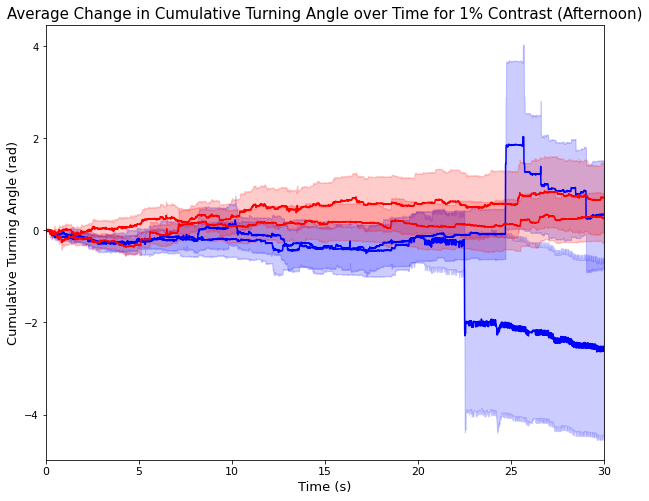

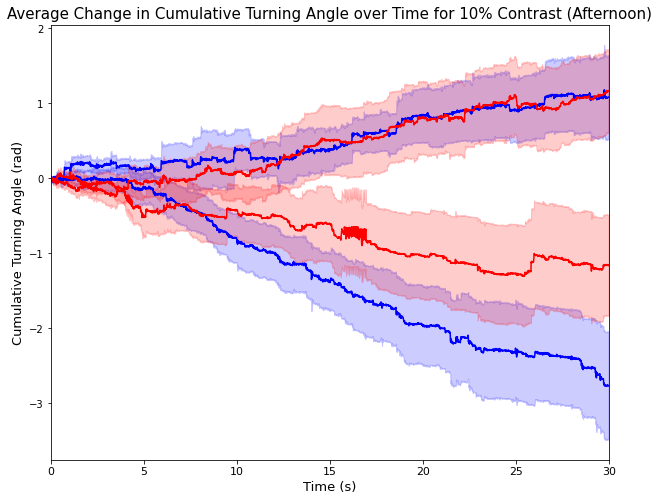

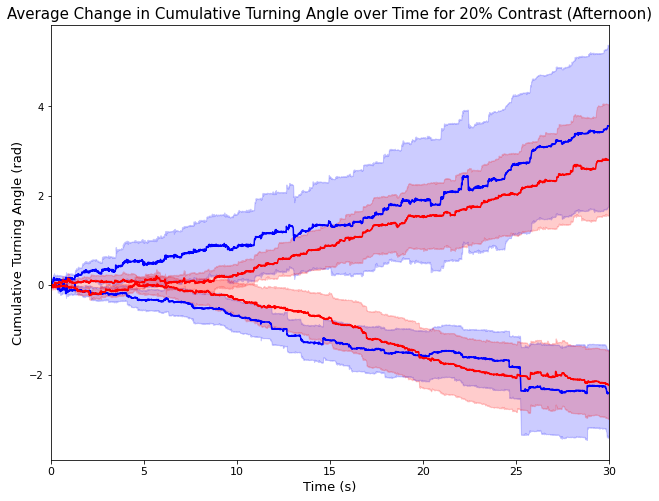

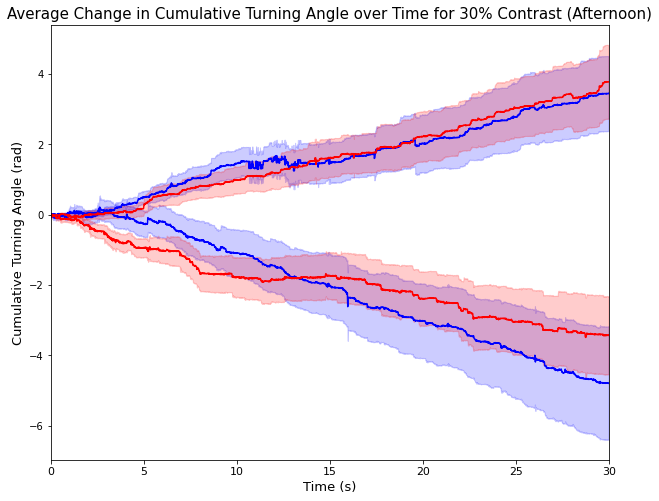

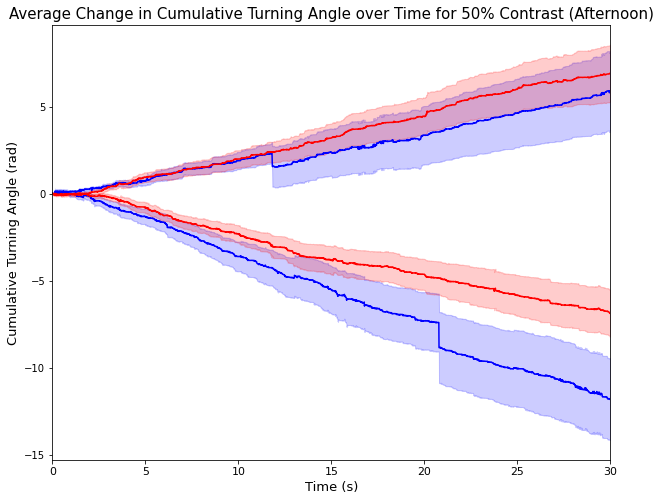

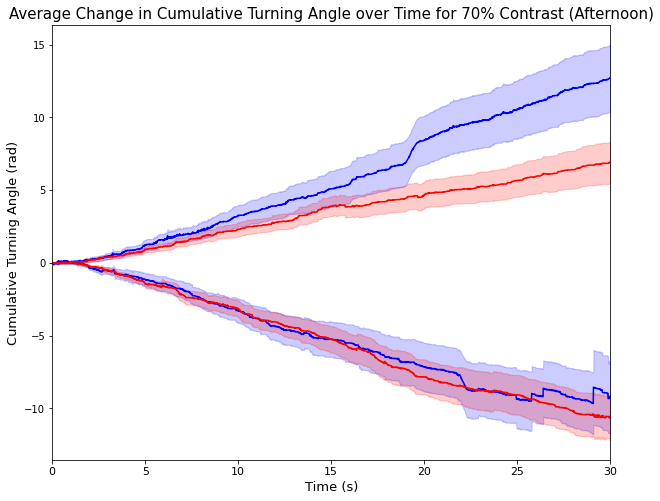

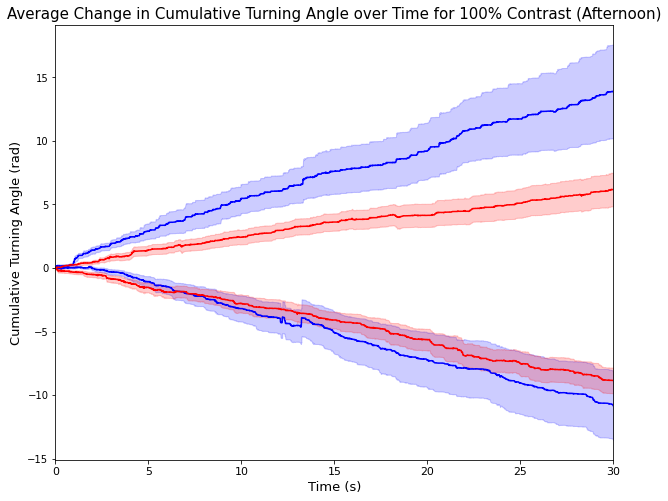

In [13]:
for c in ['1','10','20','30','50','70','100']:
    exec(f'avg_pm_LeC{c}_trajectory = np.mean(pm_comb_LeC{c}[:,:,4],axis=0)')
    exec(f'avg_pm_ReC{c}_trajectory = np.mean(pm_comb_ReC{c}[:,:,4],axis=0)')

    exec(f'avg_pm_LeC{c}_SEM = stats.sem(pm_comb_LeC{c}[:,:,4],axis=0)')
    exec(f'avg_pm_ReC{c}_SEM = stats.sem(pm_comb_ReC{c}[:,:,4],axis=0)')
    
    exec(f'avg_pm_LmeC{c}_trajectory = np.mean(pm_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_pm_RmeC{c}_trajectory = np.mean(pm_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'avg_pm_LmeC{c}_SEM = stats.sem(pm_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_pm_RmeC{c}_SEM = stats.sem(pm_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'fig, ax = plt.subplots(1,1,figsize=(10,8))')
    exec(f'plt.title("Average Change in Cumulative Turning Angle over Time for {c}% Contrast (Afternoon)",fontsize=15)')
    exec(f'ax.set_xlabel("Time (s)",fontsize=13)')
    exec(f'ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)')
    exec(f'ax.set_xlim(0,3000)')
    exec(f'x_ticks = [0, 500, 1000, 1500, 2000, 2500, 3000]')
    exec(f'x_labels = [0, 5, 10, 15, 20, 25, 30] ')
    exec(f'plt.xticks(x_ticks,x_labels,fontsize=11)')
    exec(f'ax.plot(avg_pm_LeC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_pm_ReC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_pm_LmeC{c}_trajectory,c="r")')
    exec(f'ax.plot(avg_pm_RmeC{c}_trajectory,c="r")')
    exec(f'ax.fill_between(range(0,3000), avg_pm_LeC{c}_trajectory-avg_pm_LeC{c}_SEM, avg_pm_LeC{c}_trajectory+\
            avg_pm_LeC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_pm_ReC{c}_trajectory-avg_pm_ReC{c}_SEM, avg_pm_ReC{c}_trajectory+\
            avg_pm_ReC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_pm_LmeC{c}_trajectory-avg_pm_LmeC{c}_SEM, avg_pm_LmeC{c}_trajectory+\
            avg_pm_LmeC{c}_SEM,color="r",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_pm_RmeC{c}_trajectory-avg_pm_RmeC{c}_SEM, avg_pm_RmeC{c}_trajectory+\
            avg_pm_RmeC{c}_SEM,color="r",alpha=0.2)')
    exec(f'plt.show()')

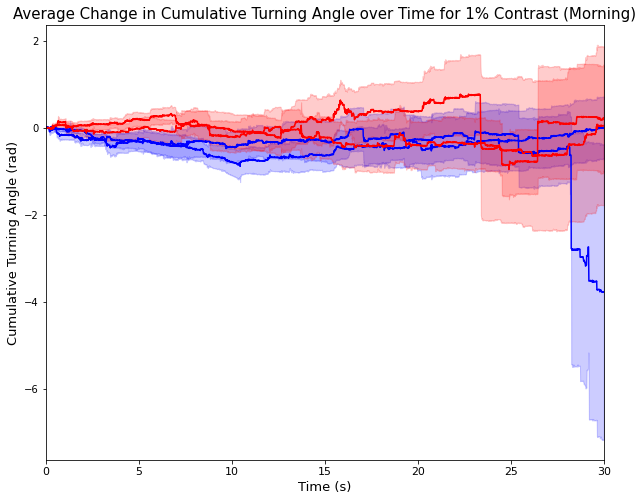

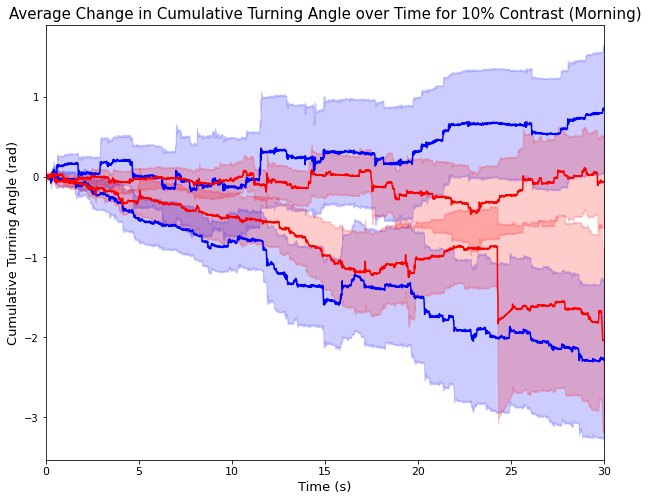

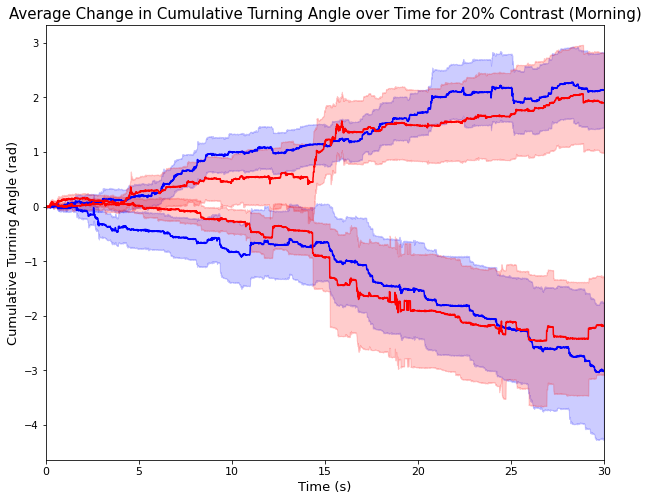

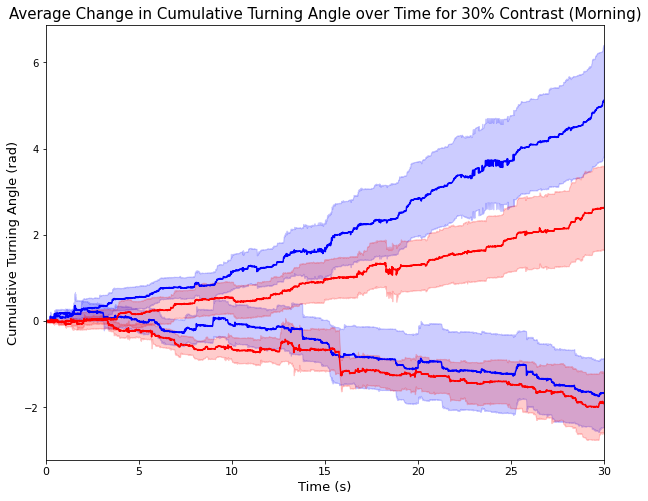

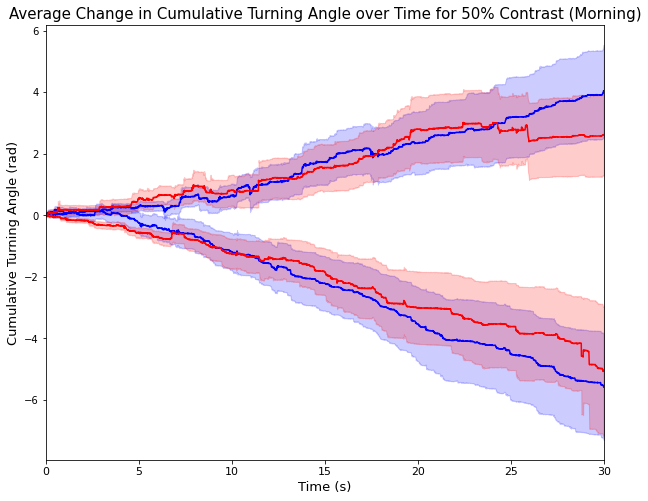

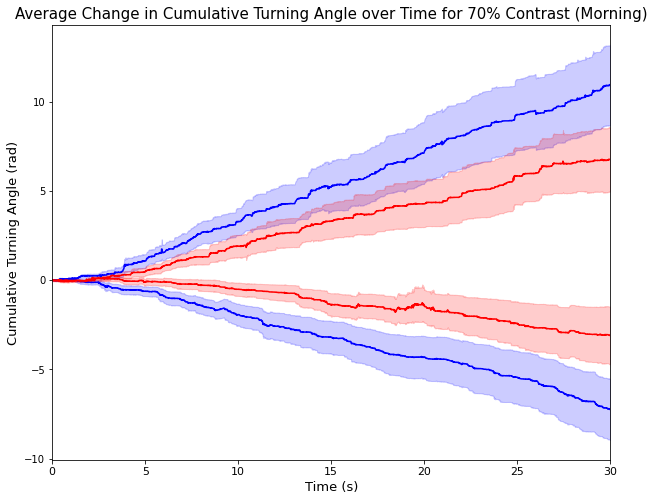

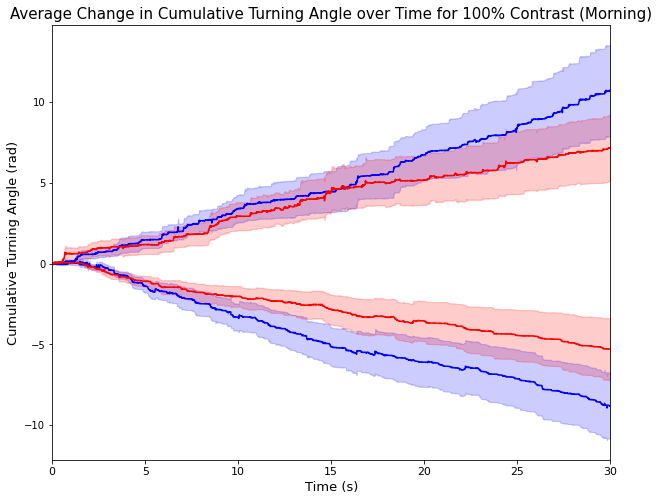

In [14]:
for c in ['1','10','20','30','50','70','100']:
    exec(f'avg_am_LeC{c}_trajectory = np.mean(am_comb_LeC{c}[:,:,4],axis=0)')
    exec(f'avg_am_ReC{c}_trajectory = np.mean(am_comb_ReC{c}[:,:,4],axis=0)')

    exec(f'avg_am_LeC{c}_SEM = stats.sem(am_comb_LeC{c}[:,:,4],axis=0)')
    exec(f'avg_am_ReC{c}_SEM = stats.sem(am_comb_ReC{c}[:,:,4],axis=0)')
    
    exec(f'avg_am_LmeC{c}_trajectory = np.mean(am_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_am_RmeC{c}_trajectory = np.mean(am_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'avg_am_LmeC{c}_SEM = stats.sem(am_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_am_RmeC{c}_SEM = stats.sem(am_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'fig, ax = plt.subplots(1,1,figsize=(10,8))')
    exec(f'plt.title("Average Change in Cumulative Turning Angle over Time for {c}% Contrast (Morning)",fontsize=15)')
    exec(f'ax.set_xlabel("Time (s)",fontsize=13)')
    exec(f'ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)')
    exec(f'ax.set_xlim(0,3000)')
    exec(f'x_ticks = [0, 500, 1000, 1500, 2000, 2500, 3000]')
    exec(f'x_labels = [0, 5, 10, 15, 20, 25, 30] ')
    exec(f'plt.xticks(x_ticks,x_labels,fontsize=11)')
    exec(f'ax.plot(avg_am_LeC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_am_ReC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_am_LmeC{c}_trajectory,c="r")')
    exec(f'ax.plot(avg_am_RmeC{c}_trajectory,c="r")')
    exec(f'ax.fill_between(range(0,3000), avg_am_LeC{c}_trajectory-avg_am_LeC{c}_SEM, avg_am_LeC{c}_trajectory+\
            avg_am_LeC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_am_ReC{c}_trajectory-avg_am_ReC{c}_SEM, avg_am_ReC{c}_trajectory+\
            avg_am_ReC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_am_LmeC{c}_trajectory-avg_am_LmeC{c}_SEM, avg_am_LmeC{c}_trajectory+\
            avg_am_LmeC{c}_SEM,color="r",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_am_RmeC{c}_trajectory-avg_am_RmeC{c}_SEM, avg_am_RmeC{c}_trajectory+\
            avg_am_RmeC{c}_SEM,color="r",alpha=0.2)')
    exec(f'plt.show()')

# Combining Left and Right Flows

In [15]:
pm_comb_ReC1[:,:,4] = abs(pm_comb_ReC1[:,:,4])
pm_comb_ReC10[:,:,4] = abs(pm_comb_ReC10[:,:,4])
pm_comb_ReC20[:,:,4] = abs(pm_comb_ReC20[:,:,4])
pm_comb_ReC30[:,:,4] = abs(pm_comb_ReC30[:,:,4])
pm_comb_ReC50[:,:,4] = abs(pm_comb_ReC50[:,:,4])
pm_comb_ReC70[:,:,4] = abs(pm_comb_ReC70[:,:,4])
pm_comb_ReC100[:,:,4] = abs(pm_comb_ReC100[:,:,4])

In [16]:
am_comb_ReC1[:,:,4] = abs(am_comb_ReC1[:,:,4])
am_comb_ReC10[:,:,4] = abs(am_comb_ReC10[:,:,4])
am_comb_ReC20[:,:,4] = abs(am_comb_ReC20[:,:,4])
am_comb_ReC30[:,:,4] = abs(am_comb_ReC30[:,:,4])
am_comb_ReC50[:,:,4] = abs(am_comb_ReC50[:,:,4])
am_comb_ReC70[:,:,4] = abs(am_comb_ReC70[:,:,4])
am_comb_ReC100[:,:,4] = abs(am_comb_ReC100[:,:,4])

In [17]:
pm_comb_RmeC1[:,:,4] = abs(pm_comb_RmeC1[:,:,4])
pm_comb_RmeC10[:,:,4] = abs(pm_comb_RmeC10[:,:,4])
pm_comb_RmeC20[:,:,4] = abs(pm_comb_RmeC20[:,:,4])
pm_comb_RmeC30[:,:,4] = abs(pm_comb_RmeC30[:,:,4])
pm_comb_RmeC50[:,:,4] = abs(pm_comb_RmeC50[:,:,4])
pm_comb_RmeC70[:,:,4] = abs(pm_comb_RmeC70[:,:,4])
pm_comb_RmeC100[:,:,4] = abs(pm_comb_RmeC100[:,:,4])

In [18]:
am_comb_RmeC1[:,:,4] = abs(am_comb_RmeC1[:,:,4])
am_comb_RmeC10[:,:,4] = abs(am_comb_RmeC10[:,:,4])
am_comb_RmeC20[:,:,4] = abs(am_comb_RmeC20[:,:,4])
am_comb_RmeC30[:,:,4] = abs(am_comb_RmeC30[:,:,4])
am_comb_RmeC50[:,:,4] = abs(am_comb_RmeC50[:,:,4])
am_comb_RmeC70[:,:,4] = abs(am_comb_RmeC70[:,:,4])
am_comb_RmeC100[:,:,4] = abs(am_comb_RmeC100[:,:,4])

In [19]:
pm_eC1 = np.vstack((pm_comb_LeC1,pm_comb_ReC1))
pm_eC10 = np.vstack((pm_comb_LeC10,pm_comb_ReC10))
pm_eC20 = np.vstack((pm_comb_LeC20,pm_comb_ReC20))
pm_eC30 = np.vstack((pm_comb_LeC30,pm_comb_ReC30))
pm_eC50 = np.vstack((pm_comb_LeC50,pm_comb_ReC50))
pm_eC70 = np.vstack((pm_comb_LeC70,pm_comb_ReC70))
pm_eC100 = np.vstack((pm_comb_LeC100,pm_comb_ReC100))

In [20]:
am_eC1 = np.vstack((am_comb_LeC1,am_comb_ReC1))
am_eC10 = np.vstack((am_comb_LeC10,am_comb_ReC10))
am_eC20 = np.vstack((am_comb_LeC20,am_comb_ReC20))
am_eC30 = np.vstack((am_comb_LeC30,am_comb_ReC30))
am_eC50 = np.vstack((am_comb_LeC50,am_comb_ReC50))
am_eC70 = np.vstack((am_comb_LeC70,am_comb_ReC70))
am_eC100 = np.vstack((am_comb_LeC100,am_comb_ReC100))

In [21]:
pm_meC1 = np.vstack((pm_comb_LmeC1,pm_comb_RmeC1))
pm_meC10 = np.vstack((pm_comb_LmeC10,pm_comb_RmeC10))
pm_meC20 = np.vstack((pm_comb_LmeC20,pm_comb_RmeC20))
pm_meC30 = np.vstack((pm_comb_LmeC30,pm_comb_RmeC30))
pm_meC50 = np.vstack((pm_comb_LmeC50,pm_comb_RmeC50))
pm_meC70 = np.vstack((pm_comb_LmeC70,pm_comb_RmeC70))
pm_meC100 = np.vstack((pm_comb_LmeC100,pm_comb_RmeC100))

In [22]:
am_meC1 = np.vstack((am_comb_LmeC1,am_comb_RmeC1))
am_meC10 = np.vstack((am_comb_LmeC10,am_comb_RmeC10))
am_meC20 = np.vstack((am_comb_LmeC20,am_comb_RmeC20))
am_meC30 = np.vstack((am_comb_LmeC30,am_comb_RmeC30))
am_meC50 = np.vstack((am_comb_LmeC50,am_comb_RmeC50))
am_meC70 = np.vstack((am_comb_LmeC70,am_comb_RmeC70))
am_meC100 = np.vstack((am_comb_LmeC100,am_comb_RmeC100))

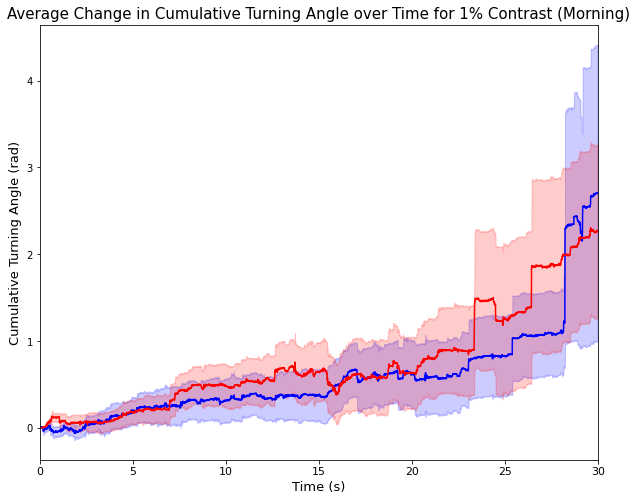

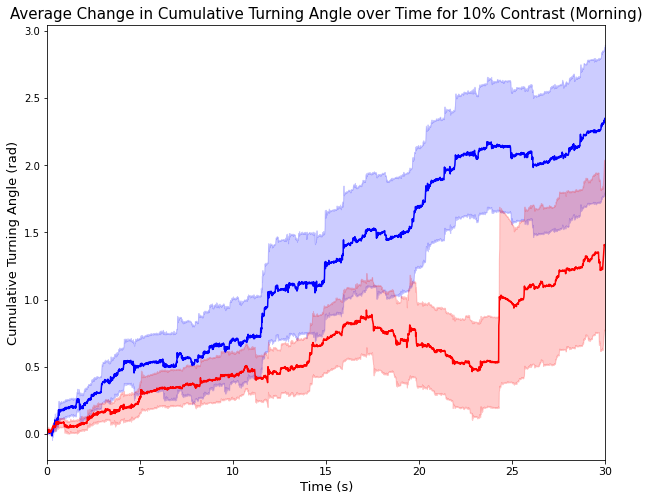

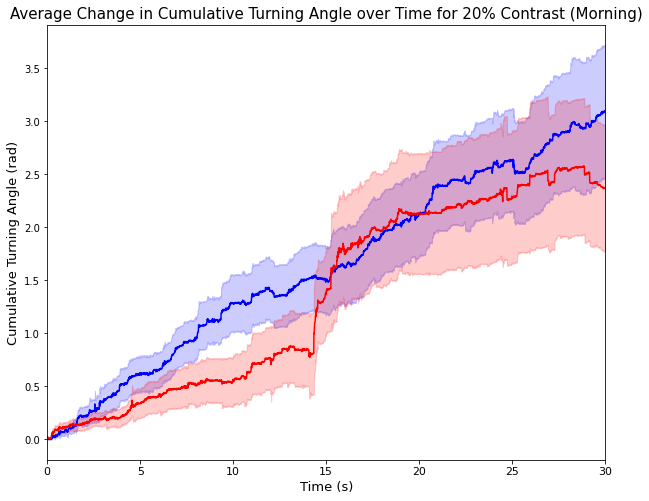

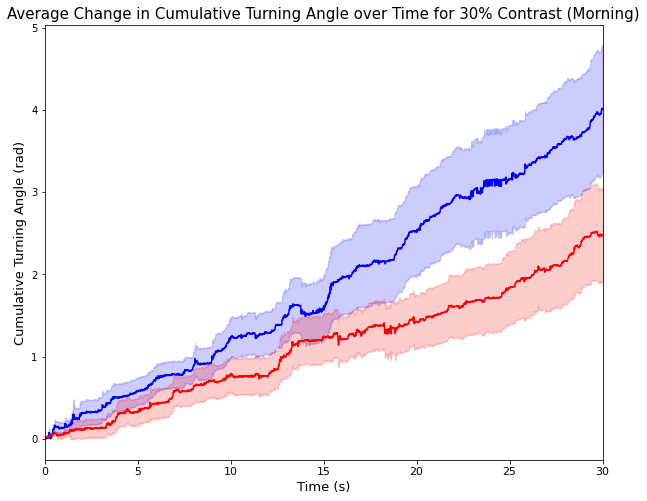

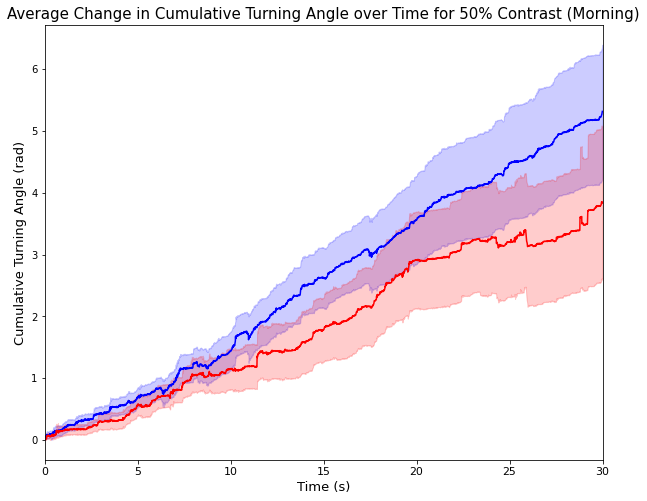

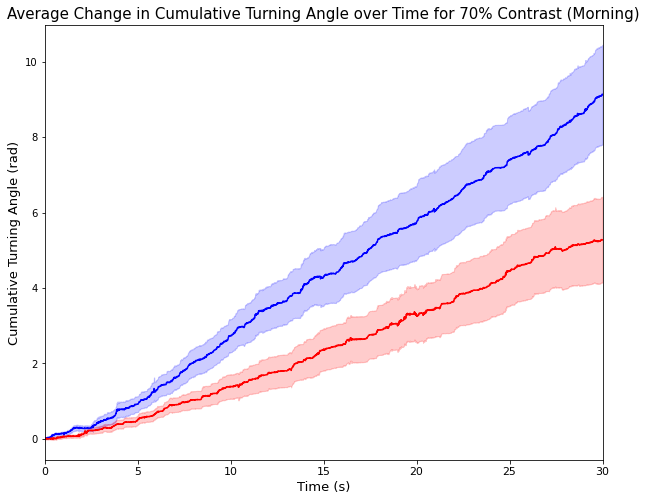

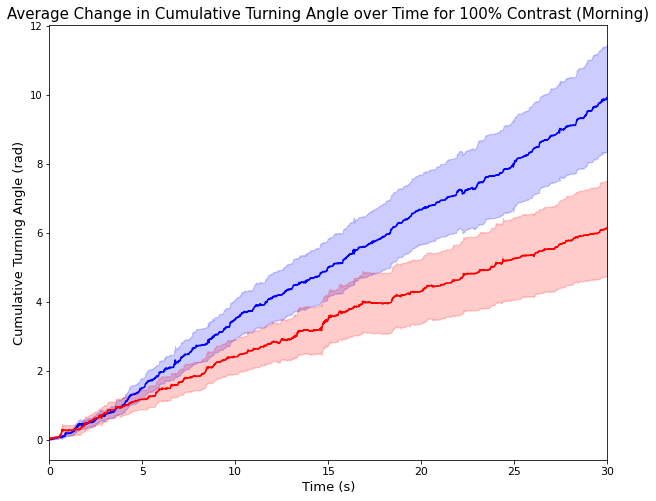

In [23]:
for c in ['1','10','20','30','50','70','100']:
    exec(f'avg_am_eC{c}_trajectory = np.mean(am_eC{c}[:,:,4],axis=0)')
#     exec(f'avg_am_eC{c}_trajectory = np.mean(am_comb_ReC{c}[:,:,4],axis=0)')

    exec(f'avg_am_eC{c}_SEM = stats.sem(am_eC{c}[:,:,4],axis=0)')
#     exec(f'avg_am_eC{c}_SEM = stats.sem(am_comb_ReC{c}[:,:,4],axis=0)')
    
    exec(f'avg_am_meC{c}_trajectory = np.mean(am_meC{c}[:,:,4],axis=0)')
#     exec(f'avg_am_meC{c}_trajectory = np.mean(am_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'avg_am_meC{c}_SEM = stats.sem(am_meC{c}[:,:,4],axis=0)')
#     exec(f'avg_am_meC{c}_SEM = stats.sem(am_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'fig, ax = plt.subplots(1,1,figsize=(10,8))')
    exec(f'plt.title("Average Change in Cumulative Turning Angle over Time for {c}% Contrast (Morning)",fontsize=15)')
    exec(f'ax.set_xlabel("Time (s)",fontsize=13)')
    exec(f'ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)')
    exec(f'ax.set_xlim(0,3000)')
    exec(f'x_ticks = [0, 500, 1000, 1500, 2000, 2500, 3000]')
    exec(f'x_labels = [0, 5, 10, 15, 20, 25, 30] ')
    exec(f'plt.xticks(x_ticks,x_labels,fontsize=11)')
    exec(f'ax.plot(avg_am_eC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_am_meC{c}_trajectory,c="r")')
#     exec(f'ax.plot(avg_am_LmeC{c}_trajectory,c="g")')
#     exec(f'ax.plot(avg_am_RmeC{c}_trajectory,c="k")')
    exec(f'ax.fill_between(range(0,3000), avg_am_eC{c}_trajectory-avg_am_eC{c}_SEM, avg_am_eC{c}_trajectory+\
            avg_am_eC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_am_meC{c}_trajectory-avg_am_meC{c}_SEM, avg_am_meC{c}_trajectory+\
            avg_am_meC{c}_SEM,color="r",alpha=0.2)')
#     exec(f'ax.fill_between(range(0,3000), avg_am_LmeC{c}_trajectory-avg_am_LmeC{c}_SEM, avg_am_LmeC{c}_trajectory+\
#             avg_am_LmeC{c}_SEM,color="g",alpha=0.2)')
#     exec(f'ax.fill_between(range(0,3000), avg_am_RmeC{c}_trajectory-avg_am_RmeC{c}_SEM, avg_am_RmeC{c}_trajectory+\
#             avg_am_RmeC{c}_SEM,color="grey",alpha=0.2)')
    exec(f'plt.show()')

# Saving Stacked Data as csv

In [181]:
pm_eC1.copy().reshape(pm_eC1.shape[0]*pm_eC1.shape[1],-1).shape

(96000, 6)

In [24]:
# pd.DataFrame(pm_eC1.copy().reshape(pm_eC1.shape[0]*pm_eC1.shape[1],-1)).to_csv('../raw_data/pm_eC1.csv')
# pd.DataFrame(pm_eC10.copy().reshape(pm_eC10.shape[0]*pm_eC10.shape[1],-1)).to_csv('../raw_data/pm_eC10.csv')
# pd.DataFrame(pm_eC20.copy().reshape(pm_eC20.shape[0]*pm_eC20.shape[1],-1)).to_csv('../raw_data/pm_eC20.csv')
# pd.DataFrame(pm_eC30.copy().reshape(pm_eC30.shape[0]*pm_eC30.shape[1],-1)).to_csv('../raw_data/pm_eC30.csv')
# pd.DataFrame(pm_eC50.copy().reshape(pm_eC50.shape[0]*pm_eC50.shape[1],-1)).to_csv('../raw_data/pm_eC50.csv')
# pd.DataFrame(pm_eC70.copy().reshape(pm_eC70.shape[0]*pm_eC70.shape[1],-1)).to_csv('../raw_data/pm_eC70.csv')
# pd.DataFrame(pm_eC100.copy().reshape(pm_eC100.shape[0]*pm_eC100.shape[1],-1)).to_csv('../raw_data/pm_eC100.csv')

In [25]:
# pd.DataFrame(pm_meC1.copy().reshape(pm_meC1.shape[0]*pm_meC1.shape[1],-1)).to_csv('../raw_data/pm_meC1.csv')
# pd.DataFrame(pm_meC10.copy().reshape(pm_meC10.shape[0]*pm_meC10.shape[1],-1)).to_csv('../raw_data/pm_meC10.csv')
# pd.DataFrame(pm_meC20.copy().reshape(pm_meC20.shape[0]*pm_meC20.shape[1],-1)).to_csv('../raw_data/pm_meC20.csv')
# pd.DataFrame(pm_meC30.copy().reshape(pm_meC30.shape[0]*pm_meC30.shape[1],-1)).to_csv('../raw_data/pm_meC30.csv')
# pd.DataFrame(pm_meC50.copy().reshape(pm_meC50.shape[0]*pm_meC50.shape[1],-1)).to_csv('../raw_data/pm_meC50.csv')
# pd.DataFrame(pm_meC70.copy().reshape(pm_meC70.shape[0]*pm_meC70.shape[1],-1)).to_csv('../raw_data/pm_meC70.csv')
# pd.DataFrame(pm_meC100.copy().reshape(pm_meC100.shape[0]*pm_meC100.shape[1],-1)).to_csv('../raw_data/pm_meC100.csv')

In [26]:
# pd.DataFrame(am_eC1.copy().reshape(am_eC1.shape[0]*am_eC1.shape[1],-1)).to_csv('../raw_data/am_eC1.csv')
# pd.DataFrame(am_eC10.copy().reshape(am_eC10.shape[0]*am_eC10.shape[1],-1)).to_csv('../raw_data/am_eC10.csv')
# pd.DataFrame(am_eC20.copy().reshape(am_eC20.shape[0]*am_eC20.shape[1],-1)).to_csv('../raw_data/am_eC20.csv')
# pd.DataFrame(am_eC30.copy().reshape(am_eC30.shape[0]*am_eC30.shape[1],-1)).to_csv('../raw_data/am_eC30.csv')
# pd.DataFrame(am_eC50.copy().reshape(am_eC50.shape[0]*am_eC50.shape[1],-1)).to_csv('../raw_data/am_eC50.csv')
# pd.DataFrame(am_eC70.copy().reshape(am_eC70.shape[0]*am_eC70.shape[1],-1)).to_csv('../raw_data/am_eC70.csv')
# pd.DataFrame(am_eC100.copy().reshape(am_eC100.shape[0]*am_eC100.shape[1],-1)).to_csv('../raw_data/am_eC100.csv')

In [27]:
# pd.DataFrame(am_meC1.copy().reshape(am_meC1.shape[0]*am_meC1.shape[1],-1)).to_csv('../raw_data/am_meC1.csv')
# pd.DataFrame(am_meC10.copy().reshape(am_meC10.shape[0]*am_meC10.shape[1],-1)).to_csv('../raw_data/am_meC10.csv')
# pd.DataFrame(am_meC20.copy().reshape(am_meC20.shape[0]*am_meC20.shape[1],-1)).to_csv('../raw_data/am_meC20.csv')
# pd.DataFrame(am_meC30.copy().reshape(am_meC30.shape[0]*am_meC30.shape[1],-1)).to_csv('../raw_data/am_meC30.csv')
# pd.DataFrame(am_meC50.copy().reshape(am_meC50.shape[0]*am_meC50.shape[1],-1)).to_csv('../raw_data/am_meC50.csv')
# pd.DataFrame(am_meC70.copy().reshape(am_meC70.shape[0]*am_meC70.shape[1],-1)).to_csv('../raw_data/am_meC70.csv')
# pd.DataFrame(am_meC100.copy().reshape(am_meC100.shape[0]*am_meC100.shape[1],-1)).to_csv('../raw_data/am_meC100.csv')

# Calculation of Mean and SEM of Cumulative Angles

In [28]:
pm_eC1_cum = pm_eC1[:,-1,4]
pm_eC10_cum = pm_eC10[:,-1,4]
pm_eC20_cum = pm_eC20[:,-1,4]
pm_eC30_cum = pm_eC30[:,-1,4]
pm_eC50_cum = pm_eC50[:,-1,4]
pm_eC70_cum = pm_eC70[:,-1,4]
pm_eC100_cum = pm_eC100[:,-1,4]

In [29]:
am_eC1_cum = am_eC1[:,-1,4]
am_eC10_cum = am_eC10[:,-1,4]
am_eC20_cum = am_eC20[:,-1,4]
am_eC30_cum = am_eC30[:,-1,4]
am_eC50_cum = am_eC50[:,-1,4]
am_eC70_cum = am_eC70[:,-1,4]
am_eC100_cum = am_eC100[:,-1,4]

In [30]:
pm_meC1_cum = pm_meC1[:,-1,4]
pm_meC10_cum = pm_meC10[:,-1,4]
pm_meC20_cum = pm_meC20[:,-1,4]
pm_meC30_cum = pm_meC30[:,-1,4]
pm_meC50_cum = pm_meC50[:,-1,4]
pm_meC70_cum = pm_meC70[:,-1,4]
pm_meC100_cum = pm_meC100[:,-1,4]

In [31]:
am_meC1_cum = am_meC1[:,-1,4]
am_meC10_cum = am_meC10[:,-1,4]
am_meC20_cum = am_meC20[:,-1,4]
am_meC30_cum = am_meC30[:,-1,4]
am_meC50_cum = am_meC50[:,-1,4]
am_meC70_cum = am_meC70[:,-1,4]
am_meC100_cum = am_meC100[:,-1,4]

In [32]:
pm_eC1_sem = stats.sem(pm_eC1[:,-1,4])
pm_eC10_sem = stats.sem(pm_eC10[:,-1,4])
pm_eC20_sem = stats.sem(pm_eC20[:,-1,4])
pm_eC30_sem = stats.sem(pm_eC30[:,-1,4])
pm_eC50_sem = stats.sem(pm_eC50[:,-1,4])
pm_eC70_sem = stats.sem(pm_eC70[:,-1,4])
pm_eC100_sem = stats.sem(pm_eC100[:,-1,4])

In [33]:
am_eC1_sem = stats.sem(am_eC1[:,-1,4])
am_eC10_sem = stats.sem(am_eC10[:,-1,4])
am_eC20_sem = stats.sem(am_eC20[:,-1,4])
am_eC30_sem = stats.sem(am_eC30[:,-1,4])
am_eC50_sem = stats.sem(am_eC50[:,-1,4])
am_eC70_sem = stats.sem(am_eC70[:,-1,4])
am_eC100_sem = stats.sem(am_eC100[:,-1,4])

In [34]:
pm_meC1_sem = stats.sem(pm_meC1[:,-1,4])
pm_meC10_sem = stats.sem(pm_meC10[:,-1,4])
pm_meC20_sem = stats.sem(pm_meC20[:,-1,4])
pm_meC30_sem = stats.sem(pm_meC30[:,-1,4])
pm_meC50_sem = stats.sem(pm_meC50[:,-1,4])
pm_meC70_sem = stats.sem(pm_meC70[:,-1,4])
pm_meC100_sem = stats.sem(pm_meC100[:,-1,4])

In [35]:
am_meC1_sem = stats.sem(am_meC1[:,-1,4])
am_meC10_sem = stats.sem(am_meC10[:,-1,4])
am_meC20_sem = stats.sem(am_meC20[:,-1,4])
am_meC30_sem = stats.sem(am_meC30[:,-1,4])
am_meC50_sem = stats.sem(am_meC50[:,-1,4])
am_meC70_sem = stats.sem(am_meC70[:,-1,4])
am_meC100_sem = stats.sem(am_meC100[:,-1,4])

In [36]:
x = [1,10,20,30,50,70,100]
pm_e_yerr = [pm_eC1_sem,pm_eC10_sem,pm_eC20_sem,pm_eC30_sem,pm_eC50_sem,pm_eC70_sem,pm_eC100_sem]
pm_me_yerr = [pm_meC1_sem,pm_meC10_sem,pm_meC20_sem,pm_meC30_sem,pm_meC50_sem,pm_meC70_sem,pm_meC100_sem]
am_e_yerr = [am_eC1_sem,am_eC10_sem,am_eC20_sem,am_eC30_sem,am_eC50_sem,am_eC70_sem,am_eC100_sem]
am_me_yerr = [am_meC1_sem,am_meC10_sem,am_meC20_sem,am_meC30_sem,am_meC50_sem,am_meC70_sem,am_meC100_sem]

pm_e_cum = [np.mean(pm_eC1_cum),np.mean(pm_eC10_cum),np.mean(pm_eC20_cum),np.mean(pm_eC30_cum),\
                                 np.mean(pm_eC50_cum),np.mean(pm_eC70_cum),np.mean(pm_eC100_cum)]
pm_me_cum = [np.mean(pm_meC1_cum),np.mean(pm_meC10_cum),np.mean(pm_meC20_cum),np.mean(pm_meC30_cum),\
                                 np.mean(pm_meC50_cum),np.mean(pm_meC70_cum),np.mean(pm_meC100_cum)]

am_e_cum = [np.mean(am_eC1_cum),np.mean(am_eC10_cum),np.mean(am_eC20_cum),np.mean(am_eC30_cum),\
                                 np.mean(am_eC50_cum),np.mean(am_eC70_cum),np.mean(am_eC100_cum)]
am_me_cum = [np.mean(am_meC1_cum),np.mean(am_meC10_cum),np.mean(am_meC20_cum),np.mean(am_meC30_cum),\
                                 np.mean(am_meC50_cum),np.mean(am_meC70_cum),np.mean(am_meC100_cum)]

# Fitting Sigmoid Curve

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_53412/2780036809.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0)))+b


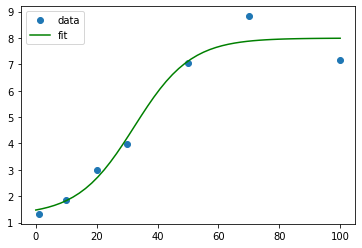

In [37]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

xdata = [1,10,20,30,50,70,100]
ydata = pm_me_cum

p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')

y = sigmoid(xdata, *popt)
new_x = np.linspace(0,100,50)
new_y = sigmoid(new_x, *popt)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(new_x,new_y,'g-',label='fit')
plt.legend()

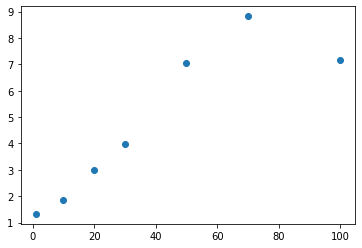

In [38]:
plt.plot(xdata,ydata,'o')

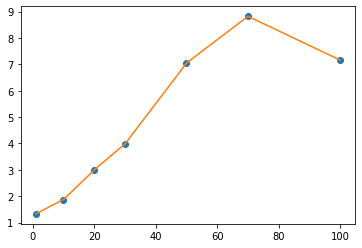

In [39]:
x = [1,10,20,30,50,70,100]
y = pm_me_cum
f = interpolate.interp1d(x, y)
xnew = np.arange(1, 100, 0.01)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

In [40]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

# xdata = [1,10,20,30,50,70,100]
# ydata = pm_me_cum

def fit_sigmoid(ydata):
    xdata = [1,10,20,30,50,70,100]
    p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')
    y = sigmoid(xdata, *popt)
    new_x = np.linspace(0,100,50)
    new_y = sigmoid(new_x, *popt)
    return new_y

In [41]:
pm_e_cum_fit = fit_sigmoid(pm_e_cum)
pm_me_cum_fit = fit_sigmoid(pm_me_cum)

am_e_cum_fit = fit_sigmoid(am_e_cum)
am_me_cum_fit = fit_sigmoid(am_me_cum)

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_53412/594421320.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0)))+b


# Contrast Response Plot

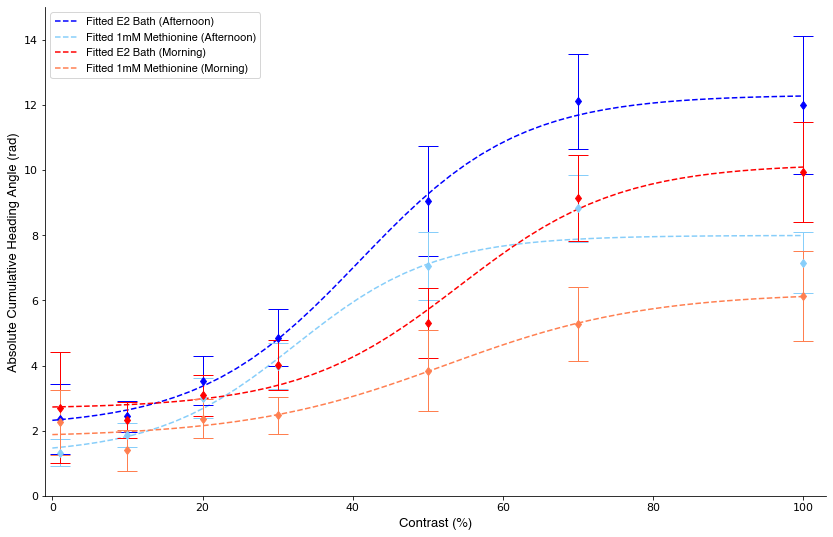

In [42]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

# ax.plot(x,pm_e_cum,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_e_cum_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_cum,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_me_cum_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
ax.errorbar(x,pm_e_cum,yerr=pm_e_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_cum,yerr=pm_me_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)


# ax.plot(x,am_e_cum,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_cum_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_cum,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_cum_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')
ax.errorbar(x,am_e_cum,yerr=am_e_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_cum,yerr=am_me_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Absolute Cumulative Heading Angle (rad)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.set_ylim(0,15)
ax.set_xlim(-1,103)
plt.savefig('../../Dissertation/contrast_function.png',dpi=400,bbox_inches='tight')
plt.show()

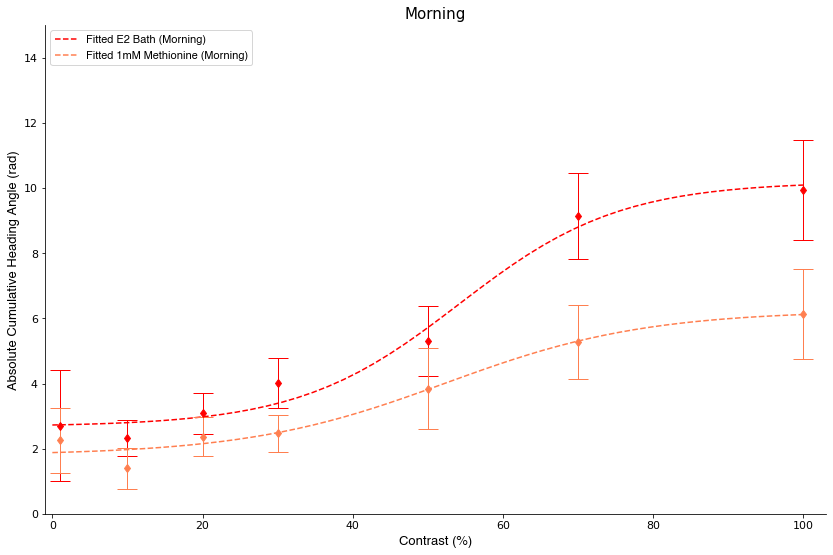

In [43]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

# ax.plot(x,am_e_cum,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_cum_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_cum,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_cum_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')
ax.errorbar(x,am_e_cum,yerr=am_e_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_cum,yerr=am_me_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font)
plt.title('Morning',size=15)
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Absolute Cumulative Heading Angle (rad)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.set_ylim(0,15)
ax.set_xlim(-1,103)
# plt.savefig('../../Dissertation/contrast_function_AM.png',dpi=400,bbox_inches='tight')
plt.show()

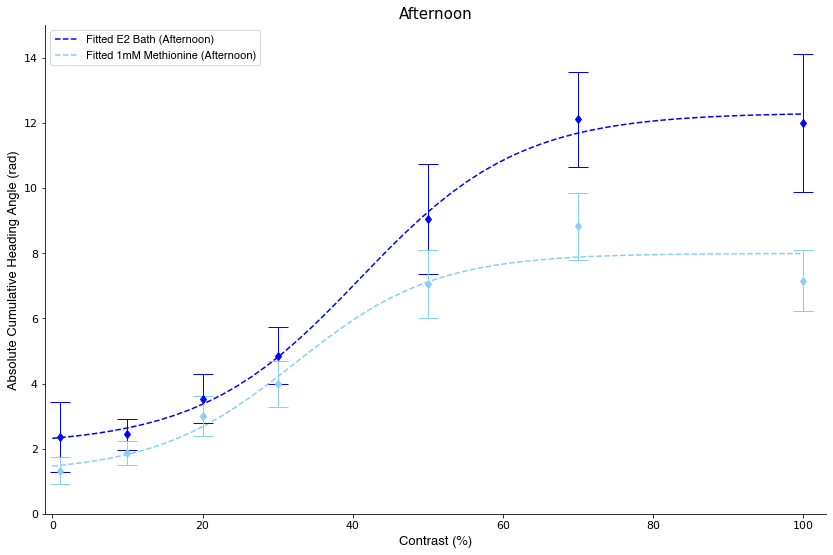

In [44]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

# ax.plot(x,pm_e_cum,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_e_cum_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_cum,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_me_cum_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
ax.errorbar(x,pm_e_cum,yerr=pm_e_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_cum,yerr=pm_me_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font)
plt.title('Afternoon',size=15)
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Absolute Cumulative Heading Angle (rad)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.set_ylim(0,15)
ax.set_xlim(-1,103)
# plt.savefig('../../Dissertation/contrast_function_PM.png',dpi=400,bbox_inches='tight')
plt.show()

# ANOVA DataFrames for Cumulative Angles

In [45]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [46]:
for m in ['e','me']:
    for t in ['pm','am']:
        for c in ['1','10','20','30','50','70','100']:
            exec(f"anova_df_{m}_{t}_{c} = pd.DataFrame(columns=['medium','time','contrast','final_cum_angle'])")
            exec(f"anova_df_{m}_{t}_{c}['final_cum_angle'] = {t}_{m}C{c}_cum")
            exec(f"anova_df_{m}_{t}_{c}['medium'] = '{m}'")
            exec(f"anova_df_{m}_{t}_{c}['time'] = '{t}'")
            exec(f"anova_df_{m}_{t}_{c}['contrast'] = {c}")

In [47]:
anova_df = pd.DataFrame(columns=['medium','time','contrast','final_cum_angle'])
anova_df = pd.concat([anova_df_e_am_1,anova_df_e_am_10,anova_df_e_am_20,anova_df_e_am_30,anova_df_e_am_50,\
                    anova_df_e_am_70,anova_df_e_am_100,\
                    anova_df_e_pm_1,anova_df_e_pm_10,anova_df_e_pm_20,anova_df_e_pm_30,anova_df_e_pm_50,\
                    anova_df_e_pm_70,anova_df_e_pm_100,\
                    anova_df_me_am_1,anova_df_me_am_10,anova_df_me_am_20,anova_df_me_am_30,anova_df_me_am_50,\
                    anova_df_me_am_70,anova_df_me_am_100,\
                    anova_df_me_pm_1,anova_df_me_pm_10,anova_df_me_pm_20,anova_df_me_pm_30,anova_df_me_pm_50,\
                    anova_df_me_pm_70,anova_df_me_pm_100])

In [48]:
anova_df_am = anova_df[anova_df['time']=='am']
anova_df_pm = anova_df[anova_df['time']=='pm']

In [49]:
# anova_df.to_csv('../raw_data/anova_df.csv')

In [50]:
anova_df = anova_df.reset_index()
anova_df = anova_df.drop(columns='index')

# Levene Test and Welch ANOVA for Cumulative Angles

In [51]:
stats.levene(anova_df_e_am_1['final_cum_angle'],anova_df_e_am_10['final_cum_angle'],\
             anova_df_e_am_20['final_cum_angle'],anova_df_e_am_30['final_cum_angle'],\
             anova_df_e_am_50['final_cum_angle'],anova_df_e_am_70['final_cum_angle'],\
             anova_df_e_am_100['final_cum_angle'],anova_df_e_pm_1['final_cum_angle'],\
             anova_df_e_pm_10['final_cum_angle'],anova_df_e_pm_20['final_cum_angle'],\
             anova_df_e_pm_30['final_cum_angle'],anova_df_e_pm_50['final_cum_angle'],\
             anova_df_e_pm_70['final_cum_angle'],anova_df_e_pm_100['final_cum_angle'],\
             anova_df_me_am_1['final_cum_angle'],anova_df_me_am_10['final_cum_angle'],\
             anova_df_me_am_20['final_cum_angle'],anova_df_me_am_30['final_cum_angle'],\
             anova_df_me_am_50['final_cum_angle'],anova_df_me_am_70['final_cum_angle'],\
             anova_df_me_am_100['final_cum_angle'],anova_df_me_pm_1['final_cum_angle'],\
             anova_df_me_pm_10['final_cum_angle'],anova_df_me_pm_20['final_cum_angle'],\
             anova_df_me_pm_30['final_cum_angle'],anova_df_me_pm_50['final_cum_angle'],\
             anova_df_me_pm_70['final_cum_angle'],anova_df_me_pm_100['final_cum_angle'])

LeveneResult(statistic=5.2767873066268285, pvalue=4.477252442963312e-16)

In [52]:
# stats.alexandergovern()

In [53]:
# stats.kruskal()

In [54]:
pg.welch_anova(data=anova_df,dv='final_cum_angle',between='time')

,Source,ddof1,ddof2,F,p-unc,np2
0,time,1,873.90096,11.212668,0.000847,0.012473


In [55]:
pg.welch_anova(data=anova_df_am,dv='final_cum_angle',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,356.794042,9.828851,0.00186,0.024425


In [56]:
pg.welch_anova(data=anova_df_pm,dv='final_cum_angle',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,349.528019,8.776036,0.003261,0.020021


In [57]:
pg.welch_anova(data=anova_df_am,dv='final_cum_angle',between='contrast')

,Source,ddof1,ddof2,F,p-unc,np2
0,contrast,6,174.238776,9.011677,1.408365e-08,0.123915


In [58]:
pg.welch_anova(data=anova_df_pm,dv='final_cum_angle',between='contrast')

,Source,ddof1,ddof2,F,p-unc,np2
0,contrast,6,198.061883,24.250009,1.907573e-21,0.233638


#  Cumulative Angles OLS & ANOVA

In [59]:
model = ols(formula='final_cum_angle ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,21144.293540,1.0,609.511892,7.373005e-102
"C(medium, Sum)",725.390979,1.0,20.910343,5.528562e-06
"C(time, Sum)",400.999554,1.0,11.559336,7.055385e-04
"C(contrast, Sum)",6379.437016,6.0,30.649268,2.101848e-33
"C(medium, Sum):C(time, Sum)",0.183913,1.0,0.005302,9.419732e-01
"C(medium, Sum):C(contrast, Sum)",387.435757,6.0,1.861390,8.468984e-02
"C(time, Sum):C(contrast, Sum)",452.929474,6.0,2.176047,4.323697e-02
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",19.551642,6.0,0.093934,9.969592e-01
Residual,29452.264090,849.0,NaN,NaN


In [60]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        final_cum_angle   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     9.281
Date:                Tue, 03 May 2022   Prob (F-statistic):           1.08e-32
Time:                        04:15:37   Log-Likelihood:                -2785.3
No. Observations:                 877   AIC:                             5627.
Df Residuals:                     849   BIC:                             5760.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         4.9978      0.202     24.688      0.000       4.600       5.395
C(medium, Sum)[S.e]                                               0.9257      0.202      4.573      0.000       0.528       1.323
C(time, Sum)[S.am]                                               -0.6883      0.202     -3.400      0.001      -1.086      -0.291
C(contrast, Sum)[S.1]                                            -2.8285      0.469     -6.032      0.000      -3.749      -1.908
C(contrast, Sum)[S.10]                                           -2.9793      0.519     -5.740      0.000      -3.998      -1.960
C(contrast, Sum)[S.20]                                           -1.9955      0.504     -3.960      0.000      -2.985      -1.006
C(contrast, Sum)[S.30]                                           -1.1621      0.490     -2.371      0.018      -2.124      -0.200
C(contrast, Sum)[S.50]                                            1.3197      0.481      2.744      0.006       0.376       2.264
C(contrast, Sum)[S.70]                                            3.8389      0.482      7.972      0.000       2.894       4.784
C(medium, Sum)[S.e]:C(time, Sum)[S.am]                           -0.0147      0.202     -0.073      0.942      -0.412       0.383
C(medium, Sum)[S.e]:C(contrast, Sum)[S.1]                        -0.5544      0.469     -1.182      0.237      -1.475       0.366
C(medium, Sum)[S.e]:C(contrast, Sum)[S.10]                       -0.5463      0.519     -1.052      0.293      -1.565       0.473
C(medium, Sum)[S.e]:C(contrast, Sum)[S.20]                       -0.6094      0.504     -1.209      0.227      -1.599       0.380
C(medium, Sum)[S.e]:C(contrast, Sum)[S.30]                       -0.3210      0.490     -0.655      0.513      -1.283       0.641
C(medium, Sum)[S.e]:C(contrast, Sum)[S.50]                       -0.0575      0.481     -0.120      0.905      -1.001       0.886
C(medium, Sum)[S.e]:C(contrast, Sum)[S.70]                        0.8593      0.482      1.784      0.075      -0.086       1.804
C(time, Sum)[S.am]:C(contrast, Sum)[S.1]                          1.0073      0.469      2.148      0.032       0.087       1.928
C(time, Sum)[S.am]:C(contrast, Sum)[S.10]                         0.5453      0.519      1.051      0.294      -0.474       1.564
C(time, Sum)[S.am]:C(contrast, Sum)[S.20]                         0.4180      0.504      0.829      0.407      -0.571       1.407
C(time, Sum)[S.am]:C(contrast, Sum)[S.30]                         0.1019      0.490      0.208      0.835      -0.860       1.064
C(time, Sum)[S.am]:C(contrast, Sum)[S.50]                        -1.0469      0.481     -2.17

In [61]:
model_am = ols(formula='final_cum_angle ~ C(medium,Sum) + C(contrast, Sum) + \
                        C(medium,Sum):C(contrast, Sum)',data=anova_df_am).fit()
anova_table_am = sm.stats.anova_lm(model_am, typ=3)
anova_table_am

,sum_sq,df,F,PR(>F)
Intercept,7406.801891,1.0,221.426107,4.667240e-40
"C(medium, Sum)",330.951587,1.0,9.893787,1.784237e-03
"C(contrast, Sum)",1901.895634,6.0,9.476185,9.850052e-10
"C(medium, Sum):C(contrast, Sum)",168.896437,6.0,0.841526,5.383774e-01
Residual,13179.475466,394.0,NaN,NaN


In [62]:
model_pm = ols(formula='final_cum_angle ~ C(medium,Sum) + C(contrast, Sum) + \
                        C(medium,Sum):C(contrast, Sum)',data=anova_df_pm).fit()
anova_table_pm = sm.stats.anova_lm(model_pm, typ=3)
anova_table_pm

,sum_sq,df,F,PR(>F)
Intercept,14578.050824,1.0,407.613795,3.418118e-65
"C(medium, Sum)",398.780882,1.0,11.150228,9.092912e-04
"C(contrast, Sum)",5280.690645,6.0,24.608712,2.761170e-25
"C(medium, Sum):C(contrast, Sum)",237.981856,6.0,1.109027,3.559308e-01
Residual,16272.788624,455.0,NaN,NaN


In [63]:
# pm_eC1.shape

In [64]:
# pm_eC1[1].shape

# Event Table Function

In [65]:
def make_event_table(contrast): 
    fish_distance = contrast[:,-1]
    if np.sum(np.isnan(fish_distance)) > 0:
        np.nan_to_num(fish_distance,copy=False,nan=0)
    t = np.arange(0, 3000, 1)
    sig = fish_distance #composite signal
    sig_clean = sig #copy for later comparison
    minsignal, maxsignal = sig.min(), sig.max()
    widths = np.arange(1, 3000)
    cwtmatr = signal.cwt(sig, signal.ricker, widths)
    t = np.arange(0, 3000, 1)
    cwt_sig = cwtmatr[25,:] #composite signal
    signal_clean = sig #copy for later comparison
    minsignal, maxsignal = cwt_sig.min(), cwt_sig.max()
    ## Compute Fourier Transform
    n = len(t)
    fhat = np.fft.fft(cwt_sig, n) #computes the fft
    psd = fhat * np.conj(fhat)/n
    freq = (1/(1*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index
    ## Filter out noise
    threshold = 1
    psd_idxs = psd > threshold #array of 0 and 1
    psd_clean = psd * psd_idxs #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal
    signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform
    fft_signal = signal_filtered.real
    fft_gauss = gaussian_filter1d(fft_signal,sigma=5)
    fish_distance_2 = []
    for frame in fft_gauss:
        if frame<=1:
            frame=0
        fish_distance_2.append(frame)
    fft_gauss = fish_distance_2
    
    # fiter out events mid-beginning and mid-end 
    if fft_gauss[0] != 0:
        zero_start = fft_gauss.index(0)
        fft_gauss[:zero_start] = [0]*(zero_start)
    if fft_gauss[-1] != 0:
        end_zero = -(fft_gauss[::-1].index(0))
        fft_gauss[end_zero:] = [0]*(-end_zero) 
    

    indices = []
    for val in fft_gauss:
        if val == 0:
            indices.append(0)
        else:
            indices.append(fft_gauss.index(val))


    df = pd.DataFrame(fft_gauss,columns=['fft_gauss'])
    df['ind'] = indices
    df['init_cum'] = contrast[:,4]
    df['init_dist'] = contrast[:,5]
    df['event'] = 0


    counter = 1 
    for index, row in df.iterrows():  
        if row['fft_gauss'] != 0:
            df.at[index,'event'] = counter
            if df.at[index+1,'fft_gauss'] == 0:
                counter += 1


    event_df = pd.DataFrame(columns=['event','duration_s','delta_theta_rad','distance','start_ind','end_ind','latency_s'])
    event_df['event'] = df['event'].unique()[1:]

    event_df['duration_s'] = [((df['event']==event).sum())/100 for event in (df['event']).unique()[1:]]

    event_df['start_ind'] = [int(df[df['event']==event].reset_index().iloc[0][0]) for event in (df['event']).unique()[1:]]
    event_df['end_ind'] = [int(df[df['event']==event].reset_index().iloc[-1][0]) for event in (df['event']).unique()[1:]]

    event_df['delta_theta_rad'] = [df['init_cum'][r['end_ind']]-df['init_cum'][r['start_ind']] \
                                   for i, r in event_df.iterrows()]

    event_df['latency_s'] = [None if i-1 == -1 else (event_df['start_ind'][i]-event_df['end_ind'][i-1])/100 \
                             for i, r in event_df.iterrows()]

    # event_df['distance'] = ADD all frames per event except first one
    event_df['distance'] = [df[df['event']==ev]['init_dist'].sum() - df[df['event']==ev]['init_dist'].reset_index()\
                            ['init_dist'][0] for ev in df['event'].unique()[1:]]

    event_df = event_df.drop(columns=['start_ind','end_ind'])
    
    return event_df




In [66]:
df_names = ['am_e_1','am_e_10','am_e_20','am_e_30','am_e_50','am_e_70','am_e_100','pm_e_1','pm_e_10','pm_e_20',\
         'pm_e_30','pm_e_50','pm_e_70','pm_e_100','am_me_1','am_me_10','am_me_20','am_me_30','am_me_50','am_me_70',\
         'am_me_100','pm_me_1','pm_me_10','pm_me_20','pm_me_30','pm_me_50','pm_me_70','pm_me_100']

In [67]:
dataframes = [am_eC1,am_eC10,am_eC20,am_eC30,am_eC50,am_eC70,am_eC100,pm_eC1,pm_eC10,pm_eC20,pm_eC30,pm_eC50,pm_eC70,\
             pm_eC100,am_meC1,am_meC10,am_meC20,am_meC30,am_meC50,am_meC70,am_meC100,pm_meC1,pm_meC10,pm_meC20,\
             pm_meC30,pm_meC50,pm_meC70,pm_meC100]

In [68]:
example_var = 'am_e_1'
int(example_var.split('_')[2])

1

In [69]:
full_event_table = pd.DataFrame(columns=['event_n','fish_n','event','duration_s','delta_theta_rad','distance',\
                                         'latency_s','time','medium','contrast'])

fish_counter = 1
for name,df in zip(df_names,dataframes):
    for fish in df:
        event_df = make_event_table(fish)
        event_df['time'] = name.split('_')[0]
        event_df['medium'] = name.split('_')[1]
        event_df['contrast'] = int(name.split('_')[2])
        event_df['event_n'] = 0
        event_df['fish_n'] = fish_counter
        fish_counter += 1
        full_event_table = pd.concat([full_event_table,event_df])
        
full_event_table['event_n'] = np.arange(1,len(full_event_table)+1,1)
full_event_table = full_event_table.set_index('event_n')

full_event_table

,fish_n,event,duration_s,delta_theta_rad,distance,latency_s,time,medium,contrast
event_n,,,,,,,,,
1,1,1,0.22,-0.01483,8.194716,NaN,am,e,1
2,1,2,0.45,0.06001,40.025167,1.42,am,e,1
3,1,3,0.42,-0.00507,24.020064,1.66,am,e,1
4,1,4,0.33,-0.01329,18.384102,2.04,am,e,1
5,1,5,0.33,-0.07148,17.717193,1.2,am,e,1
...,...,...,...,...,...,...,...,...,...
14788,877,18,0.46,1.27277,62.856581,1.04,pm,me,100
14789,877,19,0.22,0.13666,29.203317,0.49,pm,me,100
14790,877,20,0.27,0.09831,32.16117,0.45,pm,me,100


In [70]:
full_event_table.to_csv('../raw_data/full_event_table.csv')

In [71]:
# full_event_table['fish_n'].unique()

# Load Saved Event Table

In [72]:
# full_event_table = pd.read_csv('../raw_data/full_event_table.csv')

----

In [73]:
full_event_table['delta_theta_rad']=pd.to_numeric(full_event_table['delta_theta_rad'])

# Dividing Event Table into Individual DataFrames

In [74]:
pm_events = full_event_table[full_event_table['time']=='pm']

In [75]:
pm_events['delta_theta_rad']=pd.to_numeric(pm_events['delta_theta_rad'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_53412/3661766217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_events['delta_theta_rad']=pd.to_numeric(pm_events['delta_theta_rad'])


In [76]:
pm_e_events = pm_events[pm_events['medium']=='e']

In [77]:
pm_me_events = pm_events[pm_events['medium']=='me']

--------

In [78]:
am_events = full_event_table[full_event_table['time']=='am']

In [79]:
am_events['delta_theta_rad']=pd.to_numeric(am_events['delta_theta_rad'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_53412/291521083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_events['delta_theta_rad']=pd.to_numeric(am_events['delta_theta_rad'])


In [80]:
am_e_events = am_events[am_events['medium']=='e']

In [81]:
am_me_events = am_events[am_events['medium']=='me']

-----

In [82]:
am_e_C1_events = am_e_events[am_e_events['contrast']==1]
am_e_C10_events = am_e_events[am_e_events['contrast']==10]
am_e_C20_events = am_e_events[am_e_events['contrast']==20]
am_e_C30_events = am_e_events[am_e_events['contrast']==30]
am_e_C50_events = am_e_events[am_e_events['contrast']==50]
am_e_C70_events = am_e_events[am_e_events['contrast']==70]
am_e_C100_events = am_e_events[am_e_events['contrast']==100]

In [83]:
am_me_C1_events = am_me_events[am_me_events['contrast']==1]
am_me_C10_events = am_me_events[am_me_events['contrast']==10]
am_me_C20_events = am_me_events[am_me_events['contrast']==20]
am_me_C30_events = am_me_events[am_me_events['contrast']==30]
am_me_C50_events = am_me_events[am_me_events['contrast']==50]
am_me_C70_events = am_me_events[am_me_events['contrast']==70]
am_me_C100_events = am_me_events[am_me_events['contrast']==100]

In [84]:
pm_e_C1_events = pm_e_events[pm_e_events['contrast']==1]
pm_e_C10_events = pm_e_events[pm_e_events['contrast']==10]
pm_e_C20_events = pm_e_events[pm_e_events['contrast']==20]
pm_e_C30_events = pm_e_events[pm_e_events['contrast']==30]
pm_e_C50_events = pm_e_events[pm_e_events['contrast']==50]
pm_e_C70_events = pm_e_events[pm_e_events['contrast']==70]
pm_e_C100_events = pm_e_events[pm_e_events['contrast']==100]

In [85]:
pm_me_C1_events = pm_me_events[pm_me_events['contrast']==1]
pm_me_C10_events = pm_me_events[pm_me_events['contrast']==10]
pm_me_C20_events = pm_me_events[pm_me_events['contrast']==20]
pm_me_C30_events = pm_me_events[pm_me_events['contrast']==30]
pm_me_C50_events = pm_me_events[pm_me_events['contrast']==50]
pm_me_C70_events = pm_me_events[pm_me_events['contrast']==70]
pm_me_C100_events = pm_me_events[pm_me_events['contrast']==100]

# Average Turn Angle per Event (delta_theta_rad) Calculations

In [86]:
print(pm_me_C1_events['delta_theta_rad'].mean())
print(pm_me_C10_events['delta_theta_rad'].mean())
print(pm_me_C20_events['delta_theta_rad'].mean())
print(pm_me_C30_events['delta_theta_rad'].mean())
print(pm_me_C50_events['delta_theta_rad'].mean())
print(pm_me_C70_events['delta_theta_rad'].mean())
print(pm_me_C100_events['delta_theta_rad'].mean())

0.042033512370918666
0.08199863930241771
0.1249063151304345
0.19471443344294018
0.2959747058154234
0.36325720612295964
0.3732412521908128


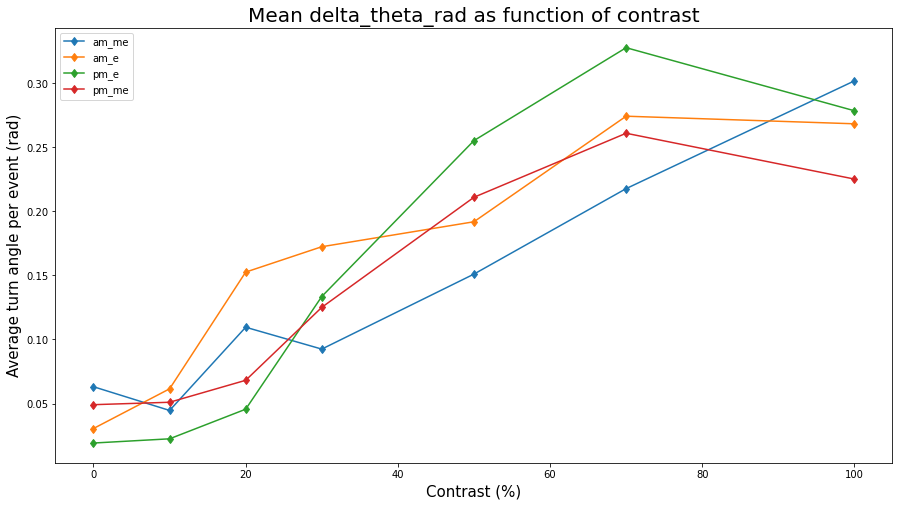

In [87]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
plt.title('Mean delta_theta_rad as function of contrast',size=20)

plt.plot([0,10,20,30,50,70,100],[0.06309584153005456,0.0445759497109824,0.10954774011299466,0.0924750176470586,\
                                 0.15103483236994197,0.21777280245398797,0.301906779263158],'-d',label='am_me')
plt.plot([0,10,20,30,50,70,100],[0.030480077720207326,0.06145861244019116,0.1525926089385474,0.17240031609195386,
                                 0.19190066826923055,0.2743170124034337,0.2683838820422535],'-d',label='am_e')
plt.plot([0,10,20,30,50,70,100],[0.019135225608058394,0.02242735987841947,0.04554144671388122,0.13352862628726303,\
                                 0.2552602469774009,0.3278077182539683,0.27856293714285724],'-d',label='pm_e')
plt.plot([0,10,20,30,50,70,100],[0.04907633120879133,0.05097382737819024,0.06811340095465399,0.12507172218604634,\
                                 0.21101560177383571,0.26099568385650185,0.22523429055137845],'-d',label='pm_me')

plt.xlabel('Contrast (%)',size=15)
plt.ylabel('Average turn angle per event (rad)',size=15)
plt.legend()
plt.show()

In [88]:
am_e_delta = [am_e_C1_events['delta_theta_rad'].mean(),am_e_C10_events['delta_theta_rad'].mean(),\
               am_e_C20_events['delta_theta_rad'].mean(),am_e_C30_events['delta_theta_rad'].mean(),\
               am_e_C50_events['delta_theta_rad'].mean(),am_e_C70_events['delta_theta_rad'].mean(),\
               am_e_C100_events['delta_theta_rad'].mean()]
am_me_delta = [am_me_C1_events['delta_theta_rad'].mean(),am_me_C10_events['delta_theta_rad'].mean(),\
               am_me_C20_events['delta_theta_rad'].mean(),am_me_C30_events['delta_theta_rad'].mean(),\
               am_me_C50_events['delta_theta_rad'].mean(),am_me_C70_events['delta_theta_rad'].mean(),\
               am_me_C100_events['delta_theta_rad'].mean()]
pm_e_delta = [pm_e_C1_events['delta_theta_rad'].mean(),pm_e_C10_events['delta_theta_rad'].mean(),\
               pm_e_C20_events['delta_theta_rad'].mean(),pm_e_C30_events['delta_theta_rad'].mean(),\
               pm_e_C50_events['delta_theta_rad'].mean(),pm_e_C70_events['delta_theta_rad'].mean(),\
               pm_e_C100_events['delta_theta_rad'].mean()]
pm_me_delta = [pm_me_C1_events['delta_theta_rad'].mean(),pm_me_C10_events['delta_theta_rad'].mean(),\
               pm_me_C20_events['delta_theta_rad'].mean(),pm_me_C30_events['delta_theta_rad'].mean(),\
               pm_me_C50_events['delta_theta_rad'].mean(),pm_me_C70_events['delta_theta_rad'].mean(),\
               pm_me_C100_events['delta_theta_rad'].mean()]

In [89]:
am_e_C1_delta_sem = stats.sem(am_e_C1_events['delta_theta_rad'])
am_e_C10_delta_sem = stats.sem(am_e_C10_events['delta_theta_rad'])
am_e_C20_delta_sem = stats.sem(am_e_C20_events['delta_theta_rad'])
am_e_C30_delta_sem = stats.sem(am_e_C30_events['delta_theta_rad'])
am_e_C50_delta_sem = stats.sem(am_e_C50_events['delta_theta_rad'])
am_e_C70_delta_sem = stats.sem(am_e_C70_events['delta_theta_rad'])
am_e_C100_delta_sem = stats.sem(am_e_C100_events['delta_theta_rad'])

In [90]:
am_me_C1_delta_sem = stats.sem(am_me_C1_events['delta_theta_rad'])
am_me_C10_delta_sem = stats.sem(am_me_C10_events['delta_theta_rad'])
am_me_C20_delta_sem = stats.sem(am_me_C20_events['delta_theta_rad'])
am_me_C30_delta_sem = stats.sem(am_me_C30_events['delta_theta_rad'])
am_me_C50_delta_sem = stats.sem(am_me_C50_events['delta_theta_rad'])
am_me_C70_delta_sem = stats.sem(am_me_C70_events['delta_theta_rad'])
am_me_C100_delta_sem = stats.sem(am_me_C100_events['delta_theta_rad'])

In [91]:
pm_e_C1_delta_sem = stats.sem(pm_e_C1_events['delta_theta_rad'])
pm_e_C10_delta_sem = stats.sem(pm_e_C10_events['delta_theta_rad'])
pm_e_C20_delta_sem = stats.sem(pm_e_C20_events['delta_theta_rad'])
pm_e_C30_delta_sem = stats.sem(pm_e_C30_events['delta_theta_rad'])
pm_e_C50_delta_sem = stats.sem(pm_e_C50_events['delta_theta_rad'])
pm_e_C70_delta_sem = stats.sem(pm_e_C70_events['delta_theta_rad'])
pm_e_C100_delta_sem = stats.sem(pm_e_C100_events['delta_theta_rad'])

In [92]:
pm_me_C1_delta_sem = stats.sem(pm_me_C1_events['delta_theta_rad'])
pm_me_C10_delta_sem = stats.sem(pm_me_C10_events['delta_theta_rad'])
pm_me_C20_delta_sem = stats.sem(pm_me_C20_events['delta_theta_rad'])
pm_me_C30_delta_sem = stats.sem(pm_me_C30_events['delta_theta_rad'])
pm_me_C50_delta_sem = stats.sem(pm_me_C50_events['delta_theta_rad'])
pm_me_C70_delta_sem = stats.sem(pm_me_C70_events['delta_theta_rad'])
pm_me_C100_delta_sem = stats.sem(pm_me_C100_events['delta_theta_rad'])

In [93]:
am_e_delta_yerr = [am_e_C1_delta_sem,am_e_C10_delta_sem,am_e_C20_delta_sem,am_e_C30_delta_sem,am_e_C50_delta_sem,\
                   am_e_C70_delta_sem,am_e_C100_delta_sem]
am_me_delta_yerr = [am_me_C1_delta_sem,am_me_C10_delta_sem,am_me_C20_delta_sem,am_me_C30_delta_sem,am_me_C50_delta_sem,\
                   am_me_C70_delta_sem,am_me_C100_delta_sem]
pm_e_delta_yerr = [pm_e_C1_delta_sem,pm_e_C10_delta_sem,pm_e_C20_delta_sem,pm_e_C30_delta_sem,pm_e_C50_delta_sem,\
                   pm_e_C70_delta_sem,pm_e_C100_delta_sem]
pm_me_delta_yerr = [pm_me_C1_delta_sem,pm_me_C10_delta_sem,pm_me_C20_delta_sem,pm_me_C30_delta_sem,pm_me_C50_delta_sem,\
                   pm_me_C70_delta_sem,pm_me_C100_delta_sem]

In [94]:
am_e_delta_fit = fit_sigmoid(am_e_delta)
am_me_delta_fit = fit_sigmoid(am_me_delta)
pm_e_delta_fit = fit_sigmoid(pm_e_delta)
pm_me_delta_fit = fit_sigmoid(pm_me_delta)

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_53412/594421320.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0)))+b


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

# Average Turn Angle per Event Plot

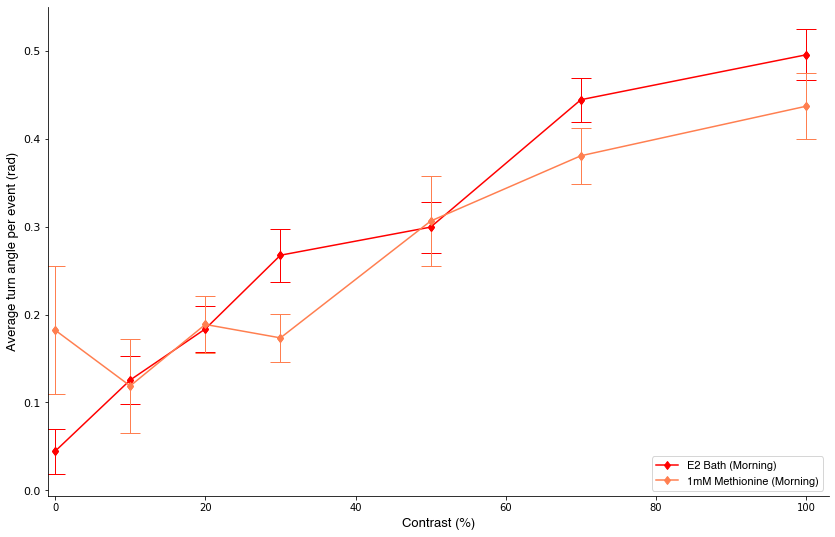

In [95]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

x = [0,10,20,30,50,70,100]

# ax.plot(x,pm_e_delta,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
# ax.plot(np.linspace(0,100,50),pm_e_delta_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_delta,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
# ax.plot(np.linspace(0,100,50),pm_me_delta_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
     
ax.plot(x,am_e_delta,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
# ax.plot(np.linspace(0,100,50),am_e_delta_fit,'--r',label='Fitted E2 Bath (Morning)')
ax.plot(x,am_me_delta,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
# ax.plot(np.linspace(0,100,50),am_me_delta_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')


# ax.errorbar(x,pm_e_delta,yerr=pm_e_delta_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
# ax.errorbar(x,pm_me_delta,yerr=pm_me_delta_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

ax.errorbar(x,am_e_delta,yerr=am_e_delta_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_delta,yerr=am_me_delta_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='lower right',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Average turn angle per event (rad)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
# plt.xticks(ticks=x_ticks, labels=x_labels,fontsize=11)
plt.yticks(fontsize=11)
# ax.set_ylim(0,0.4)
ax.set_xlim(-1,103)
plt.savefig('../../Dissertation/bout_angle_function.png',dpi=400,bbox_inches='tight')
plt.show()

In [96]:
# full_event_table.info()

# Delta_theta_rad OLS and ANOVA

In [97]:
bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=full_event_table).fit()
anova_table_bout = sm.stats.anova_lm(bout_angle_model, typ=3)
anova_table_bout

,sum_sq,df,F,PR(>F)
Intercept,826.839136,1.0,1486.824839,5.227252e-310
"C(medium, Sum)",3.311209,1.0,5.954226,1.469372e-02
"C(time, Sum)",1.829920,1.0,3.290568,6.969923e-02
"C(contrast, Sum)",225.549616,6.0,67.597343,2.573572e-83
"C(medium, Sum):C(time, Sum)",1.477737,1.0,2.657271,1.030988e-01
"C(medium, Sum):C(contrast, Sum)",3.983798,6.0,1.193946,3.060439e-01
"C(time, Sum):C(contrast, Sum)",1.501892,6.0,0.450118,8.453498e-01
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",6.676681,6.0,2.001005,6.190688e-02
Residual,8210.417715,14764.0,NaN,NaN


In [98]:
am_bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=am_events).fit()
anova_table_bout_am = sm.stats.anova_lm(am_bout_angle_model, typ=3)
anova_table_bout_am

,sum_sq,df,F,PR(>F)
Intercept,362.789634,1.0,683.789502,4.385160e-142
"C(medium, Sum)",0.146033,1.0,0.275244,5.998568e-01
"C(contrast, Sum)",87.501323,6.0,27.487227,1.721590e-32
"C(medium, Sum):C(contrast, Sum)",7.132064,6.0,2.240431,3.668076e-02
Residual,2886.763241,5441.0,NaN,NaN


In [99]:
pm_bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=pm_events).fit()
anova_table_bout_pm = sm.stats.anova_lm(pm_bout_angle_model, typ=3)
anova_table_bout_pm

,sum_sq,df,F,PR(>F)
Intercept,500.114196,1.0,875.820298,4.764333e-184
"C(medium, Sum)",6.136268,1.0,10.746081,1.048830e-03
"C(contrast, Sum)",161.531965,6.0,47.146890,2.931953e-57
"C(medium, Sum):C(contrast, Sum)",2.426316,6.0,0.708177,6.430192e-01
Residual,5323.654474,9323.0,NaN,NaN


In [100]:
pg.welch_anova(data=am_events,dv='delta_theta_rad',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,4294.411428,1.648927,0.199174,0.000319


In [101]:
pg.pairwise_gameshowell(data=am_events,dv='delta_theta_rad',between='medium')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,e,me,0.276066,0.249568,0.026497,0.020635,1.284106,4294.411428,0.199174,0.03485


In [102]:
pg.welch_anova(data=pm_events,dv='delta_theta_rad',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,6101.743031,15.892713,0.000068,0.001859


In [103]:
pg.pairwise_gameshowell(data=pm_events,dv='delta_theta_rad',between='medium')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,e,me,0.276701,0.210343,0.066358,0.016646,3.986567,6101.743031,0.000068,0.082732


# Fish List Function

In [104]:
def sem_with_zero_division_exception(events,fish):
    try:
        return stats.sem(events.loc[(events['fish_n']==fish)]['latency_s'][1:]) 
    except ZeroDivisionError as e:
        return None

def make_fish_list(events):    
    fish_list = pd.DataFrame(columns=['fish_n','bouts_Hz','duration_avg','duration_sem','latency_avg',\
                                      'latency_sem','distance_avg','distance_sem','total_distance'])


    fish_list['fish_n'] = [fish for fish in events['fish_n'].unique()]
    fish_list['bouts_Hz'] = [events.loc[(events['fish_n']==fish)].max()[1]/30 \
                             for fish in events['fish_n'].unique()]
    fish_list['duration_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['duration_s']) \
                                 for fish in events['fish_n'].unique()]
    fish_list['duration_sem'] = [stats.sem(events.loc[(events['fish_n']==fish)]['duration_s']) \
                                 for fish in events['fish_n'].unique()]
    fish_list['latency_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['latency_s']) \
                                for fish in events['fish_n'].unique()]
    fish_list['latency_sem'] = [sem_with_zero_division_exception(events,fish) \
                                for fish in events['fish_n'].unique()]
    fish_list['distance_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['distance']) \
                                for fish in events['fish_n'].unique()]
    fish_list['distance_sem'] = [stats.sem(events.loc[(events['fish_n']==fish)]['distance']) \
                               for fish in events['fish_n'].unique()]
    fish_list['total_distance'] = [events.loc[(events['fish_n']==fish)]['distance'].sum() \
                                  for fish in events['fish_n'].unique()]
    # fish_list['final_cumulative_angle'] = None

    return fish_list

# Making Fish Lists 

In [105]:
am_me_C100_events

,fish_n,event,duration_s,delta_theta_rad,distance,latency_s,time,medium,contrast
event_n,,,,,,,,,
9441,590,1,0.45,0.555560,53.094698,NaN,am,me,100
9442,590,2,0.5,0.611118,51.113862,0.61,am,me,100
9443,590,3,0.32,1.139660,40.316268,6.06,am,me,100
9444,590,4,0.43,0.585351,55.287638,0.25,am,me,100
9445,590,5,0.46,0.701935,48.282195,1.32,am,me,100
...,...,...,...,...,...,...,...,...,...
9775,616,2,0.53,1.431728,81.394726,11.59,am,me,100
9776,616,3,0.44,-0.329655,31.252121,1.15,am,me,100
9777,616,4,0.21,-0.031806,12.986494,1.32,am,me,100


In [106]:
am_me_C100_events[am_me_C100_events['delta_theta_rad']<-35]

,fish_n,event,duration_s,delta_theta_rad,distance,latency_s,time,medium,contrast
event_n,,,,,,,,,


In [107]:
fish_list_df_names = ['am_e_1','am_e_10','am_e_20','am_e_30','am_e_50','am_e_70','am_e_100',\
                      'pm_e_1','pm_e_10','pm_e_20','pm_e_30','pm_e_50','pm_e_70','pm_e_100',\
                      'am_me_1','am_me_10','am_me_20','am_me_30','am_me_50','am_me_70','am_me_100',\
                      'pm_me_1','pm_me_10','pm_me_20','pm_me_30','pm_me_50','pm_me_70','pm_me_100']

In [108]:
fish_list_dataframes = [am_e_C1_events,am_e_C10_events,am_e_C20_events,am_e_C30_events,am_e_C50_events,\
                        am_e_C70_events,am_e_C100_events,\
                        pm_e_C1_events,pm_e_C10_events,pm_e_C20_events,pm_e_C30_events,pm_e_C50_events,\
                        pm_e_C70_events,pm_e_C100_events,\
                        am_me_C1_events,am_me_C10_events,am_me_C20_events,am_me_C30_events,am_me_C50_events,\
                        am_me_C70_events,am_me_C100_events,\
                        pm_me_C1_events,pm_me_C10_events,pm_me_C20_events,pm_me_C30_events,pm_me_C50_events,\
                        pm_me_C70_events,pm_me_C100_events]

In [109]:
full_fish_list = pd.DataFrame(columns=['fish_n','bouts_Hz','duration_avg','duration_sem','latency_avg',\
                                      'latency_sem','distance_avg','distance_sem','total_distance','time',\
                                       'medium','contrast'])

for name,df in zip(fish_list_df_names,fish_list_dataframes):
    fish_list = make_fish_list(df)
    fish_list['time'] = name.split('_')[0]
    fish_list['medium'] = name.split('_')[1]
    fish_list['contrast'] = int(name.split('_')[2])
    fish_counter += 1
    full_fish_list = pd.concat([full_fish_list,fish_list])
        
full_fish_list['fish_n'] = np.arange(1,len(full_fish_list)+1,1)
full_fish_list = full_fish_list.set_index('fish_n')

full_fish_list

/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in true_divide
  ret = ret / rcount
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in true_divide
  ret = ret / rcount
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:264: Runt

,bouts_Hz,duration_avg,duration_sem,latency_avg,latency_sem,distance_avg,distance_sem,total_distance,time,medium,contrast
fish_n,,,,,,,,,,,
1,0.466667,0.398571,0.024312,1.857692,0.367417,53.805848,18.367324,753.281874,am,e,1
2,0.033333,0.32,NaN,NaN,NaN,15.474832,NaN,15.474832,am,e,1
3,0.833333,0.414,0.015177,0.780417,0.073429,46.61023,2.788811,1165.255739,am,e,1
4,0.233333,0.468571,0.011218,3.553333,1.129657,50.007648,10.318067,350.053537,am,e,1
5,0.033333,0.34,NaN,NaN,NaN,17.218222,NaN,17.218222,am,e,1
...,...,...,...,...,...,...,...,...,...,...,...
822,0.566667,0.422353,0.038113,1.381875,0.316232,47.190811,8.009851,802.243785,pm,me,100
823,1.0,0.343,0.021952,0.633103,0.064068,51.759852,5.250618,1552.795557,pm,me,100
824,0.866667,0.403077,0.028462,0.7712,0.112456,70.79847,9.753856,1840.760211,pm,me,100


In [110]:
full_fish_list.to_csv('../raw_data/full_fish_list.csv')

In [111]:
full_fish_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 826 entries, 1 to 826
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   bouts_Hz        826 non-null    object
 1   duration_avg    826 non-null    object
 2   duration_sem    815 non-null    object
 3   latency_avg     815 non-null    object
 4   latency_sem     800 non-null    object
 5   distance_avg    826 non-null    object
 6   distance_sem    815 non-null    object
 7   total_distance  826 non-null    object
 8   time            826 non-null    object
 9   medium          826 non-null    object
 10  contrast        826 non-null    object
dtypes: object(11)
memory usage: 77.4+ KB


In [112]:
full_fish_list['bouts_Hz'] = pd.to_numeric(full_fish_list['bouts_Hz'])

In [113]:
full_fish_list['latency_avg'] = pd.to_numeric(full_fish_list['latency_avg'])

In [114]:
# full_fish_list = pd.read_csv('../raw_data/full_fish_list.csv')

# Bout Frequency OLS and ANOVA

In [115]:
bout_freq_model = ols(formula='bouts_Hz ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=full_fish_list).fit()
anova_table_bout = sm.stats.anova_lm(bout_freq_model, typ=3)
anova_table_bout

,sum_sq,df,F,PR(>F)
Intercept,275.512428,1.0,4363.193491,0.000000e+00
"C(medium, Sum)",1.048443,1.0,16.603825,5.066210e-05
"C(time, Sum)",8.000545,1.0,126.701827,2.205600e-27
"C(contrast, Sum)",0.548466,6.0,1.447643,1.935880e-01
"C(medium, Sum):C(time, Sum)",0.027554,1.0,0.436359,5.090755e-01
"C(medium, Sum):C(contrast, Sum)",0.592886,6.0,1.564887,1.544296e-01
"C(time, Sum):C(contrast, Sum)",0.388014,6.0,1.024139,4.080615e-01
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",0.103276,6.0,0.272591,9.498094e-01
Residual,50.389449,798.0,NaN,NaN


In [175]:
am_e_fish_list = am_fish_list[am_fish_list['medium'] == 'e']
am_me_fish_list = am_fish_list[am_fish_list['medium'] == 'me']

In [177]:
pm_e_fish_list = pm_fish_list[pm_fish_list['medium'] == 'e']
pm_me_fish_list = pm_fish_list[pm_fish_list['medium'] == 'me']

(array([0.40540541, 0.48648649, 0.32432432, 0.52702703, 0.81081081,
        1.58108108, 1.54054054, 1.54054054, 0.68918919, 0.2027027 ]),
 array([0.03333333, 0.15666667, 0.28      , 0.40333333, 0.52666667,
        0.65      , 0.77333333, 0.89666667, 1.02      , 1.14333333,
        1.26666667]),
 <BarContainer object of 10 artists>)

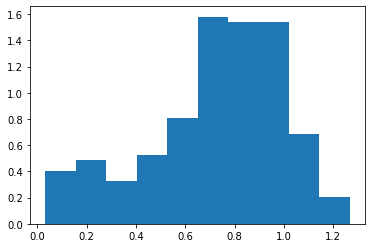

In [178]:
plt.hist(pm_e_fish_list['bouts_Hz'],density=True)

(array([0.20408163, 0.27210884, 0.88435374, 0.74829932, 1.32653061,
        1.2585034 , 1.70068027, 0.98639456, 1.08843537, 0.10204082]),
 array([0.03333333, 0.15      , 0.26666667, 0.38333333, 0.5       ,
        0.61666667, 0.73333333, 0.85      , 0.96666667, 1.08333333,
        1.2       ]),
 <BarContainer object of 10 artists>)

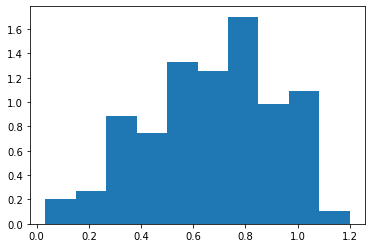

In [179]:
plt.hist(pm_me_fish_list['bouts_Hz'],density=True)

(array([0.22488756, 0.73088456, 1.23688156, 1.46176912, 1.63043478,
        1.40554723, 0.95577211, 1.011994  , 1.011994  , 0.67466267]),
 array([0.03333333, 0.13      , 0.22666667, 0.32333333, 0.42      ,
        0.51666667, 0.61333333, 0.71      , 0.80666667, 0.90333333,
        1.        ]),
 <BarContainer object of 10 artists>)

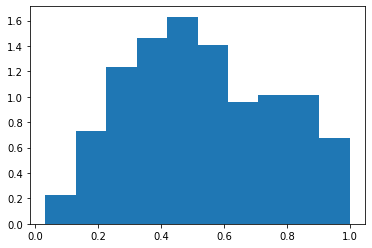

In [174]:
plt.hist(am_e_fish_list['bouts_Hz'],density=True)

(array([1.42614601, 0.86587436, 1.06960951, 1.42614601, 1.62988115,
        1.22241087, 0.81494058, 0.86587436, 0.25466893, 0.10186757]),
 array([0.03333333, 0.13666667, 0.24      , 0.34333333, 0.44666667,
        0.55      , 0.65333333, 0.75666667, 0.86      , 0.96333333,
        1.06666667]),
 <BarContainer object of 10 artists>)

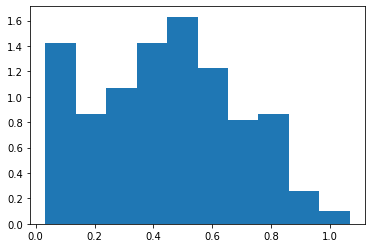

In [176]:
plt.hist(am_me_fish_list['bouts_Hz'],density=True)

In [116]:
am_fish_list = full_fish_list[full_fish_list['time'] == 'am']
pm_fish_list = full_fish_list[full_fish_list['time'] == 'pm']

In [117]:
am_bout_freq_model = ols(formula='bouts_Hz ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=am_fish_list).fit()
anova_table_bout_am = sm.stats.anova_lm(am_bout_freq_model, typ=3)
anova_table_bout_am

,sum_sq,df,F,PR(>F)
Intercept,87.719560,1.0,1528.917632,1.216819e-131
"C(medium, Sum)",0.655039,1.0,11.417082,8.073668e-04
"C(contrast, Sum)",0.160097,6.0,0.465071,8.340927e-01
"C(medium, Sum):C(contrast, Sum)",0.401422,6.0,1.166104,3.238293e-01
Residual,20.654508,360.0,NaN,NaN


In [118]:
pm_bout_freq_model = ols(formula='bouts_Hz ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=pm_fish_list).fit()
anova_table_bout_pm = sm.stats.anova_lm(pm_bout_freq_model, typ=3)
anova_table_bout_pm

,sum_sq,df,F,PR(>F)
Intercept,205.293011,1.0,3023.995845,9.560980e-199
"C(medium, Sum)",0.400382,1.0,5.897682,1.556244e-02
"C(contrast, Sum)",0.859763,6.0,2.110739,5.092152e-02
"C(medium, Sum):C(contrast, Sum)",0.285491,6.0,0.700888,6.490465e-01
Residual,29.734941,438.0,NaN,NaN


In [119]:
am_fish_list

,bouts_Hz,duration_avg,duration_sem,latency_avg,latency_sem,distance_avg,distance_sem,total_distance,time,medium,contrast
fish_n,,,,,,,,,,,
1,0.466667,0.398571,0.024312,1.857692,0.367417,53.805848,18.367324,753.281874,am,e,1
2,0.033333,0.32,NaN,NaN,NaN,15.474832,NaN,15.474832,am,e,1
3,0.833333,0.414,0.015177,0.780417,0.073429,46.61023,2.788811,1165.255739,am,e,1
4,0.233333,0.468571,0.011218,3.553333,1.129657,50.007648,10.318067,350.053537,am,e,1
5,0.033333,0.34,NaN,NaN,NaN,17.218222,NaN,17.218222,am,e,1
...,...,...,...,...,...,...,...,...,...,...,...
570,0.100000,0.46,0.017321,2.315000,0.835,46.280324,8.514622,138.840971,am,me,100
571,0.200000,0.27,0.03821,2.366000,1.44182,30.652578,6.477407,183.915466,am,me,100
572,0.333333,0.389,0.033746,1.502222,0.500832,51.118795,8.697843,511.187954,am,me,100


In [120]:
pg.welch_anova(data=am_fish_list,dv='bouts_Hz',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,371.643603,11.122001,0.000939,0.029029


In [121]:
pg.welch_anova(data=pm_fish_list,dv='bouts_Hz',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,407.661799,5.273561,0.022158,0.011828


In [122]:
am_e_fish_list = am_fish_list[am_fish_list['medium'] == 'e']
am_me_fish_list = am_fish_list[am_fish_list['medium'] == 'me']

pm_e_fish_list = pm_fish_list[pm_fish_list['medium'] == 'e']
pm_me_fish_list = pm_fish_list[pm_fish_list['medium'] == 'me']

In [123]:
am_e_1_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 1]
am_e_10_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 10]
am_e_20_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 20]
am_e_30_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 30]
am_e_50_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 50]
am_e_70_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 70]
am_e_100_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 100]

In [124]:
am_me_1_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 1]
am_me_10_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 10]
am_me_20_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 20]
am_me_30_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 30]
am_me_50_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 50]
am_me_70_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 70]
am_me_100_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 100]

In [125]:
pm_e_1_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 1]
pm_e_10_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 10]
pm_e_20_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 20]
pm_e_30_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 30]
pm_e_50_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 50]
pm_e_70_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 70]
pm_e_100_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 100]

In [126]:
pm_me_1_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 1]
pm_me_10_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 10]
pm_me_20_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 20]
pm_me_30_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 30]
pm_me_50_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 50]
pm_me_70_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 70]
pm_me_100_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 100]

# Bout Frequency Mean and SEM Calculations

In [127]:
am_e_bout_hz = [am_e_1_fish_list['bouts_Hz'].mean(),am_e_10_fish_list['bouts_Hz'].mean(),\
               am_e_20_fish_list['bouts_Hz'].mean(),am_e_30_fish_list['bouts_Hz'].mean(),\
               am_e_50_fish_list['bouts_Hz'].mean(),am_e_70_fish_list['bouts_Hz'].mean(),\
               am_e_100_fish_list['bouts_Hz'].mean()]
am_me_bout_hz = [am_me_1_fish_list['bouts_Hz'].mean(),am_me_10_fish_list['bouts_Hz'].mean(),\
               am_me_20_fish_list['bouts_Hz'].mean(),am_me_30_fish_list['bouts_Hz'].mean(),\
               am_me_50_fish_list['bouts_Hz'].mean(),am_me_70_fish_list['bouts_Hz'].mean(),\
               am_me_100_fish_list['bouts_Hz'].mean()]
pm_e_bout_hz = [pm_e_1_fish_list['bouts_Hz'].mean(),pm_e_10_fish_list['bouts_Hz'].mean(),\
               pm_e_20_fish_list['bouts_Hz'].mean(),pm_e_30_fish_list['bouts_Hz'].mean(),\
               pm_e_50_fish_list['bouts_Hz'].mean(),pm_e_70_fish_list['bouts_Hz'].mean(),\
               pm_e_100_fish_list['bouts_Hz'].mean()]
pm_me_bout_hz = [pm_me_1_fish_list['bouts_Hz'].mean(),pm_me_10_fish_list['bouts_Hz'].mean(),\
               pm_me_20_fish_list['bouts_Hz'].mean(),pm_me_30_fish_list['bouts_Hz'].mean(),\
               pm_me_50_fish_list['bouts_Hz'].mean(),pm_me_70_fish_list['bouts_Hz'].mean(),\
               pm_me_100_fish_list['bouts_Hz'].mean()]

In [128]:
am_e_1_bout_hz_sem = stats.sem(am_e_1_fish_list['bouts_Hz'])
am_e_10_bout_hz_sem = stats.sem(am_e_10_fish_list['bouts_Hz'])
am_e_20_bout_hz_sem = stats.sem(am_e_20_fish_list['bouts_Hz'])
am_e_30_bout_hz_sem = stats.sem(am_e_30_fish_list['bouts_Hz'])
am_e_50_bout_hz_sem = stats.sem(am_e_50_fish_list['bouts_Hz'])
am_e_70_bout_hz_sem = stats.sem(am_e_70_fish_list['bouts_Hz'])
am_e_100_bout_hz_sem = stats.sem(am_e_100_fish_list['bouts_Hz'])

In [129]:
am_me_1_bout_hz_sem = stats.sem(am_me_1_fish_list['bouts_Hz'])
am_me_10_bout_hz_sem = stats.sem(am_me_10_fish_list['bouts_Hz'])
am_me_20_bout_hz_sem = stats.sem(am_me_20_fish_list['bouts_Hz'])
am_me_30_bout_hz_sem = stats.sem(am_me_30_fish_list['bouts_Hz'])
am_me_50_bout_hz_sem = stats.sem(am_me_50_fish_list['bouts_Hz'])
am_me_70_bout_hz_sem = stats.sem(am_me_70_fish_list['bouts_Hz'])
am_me_100_bout_hz_sem = stats.sem(am_me_100_fish_list['bouts_Hz'])

In [130]:
pm_e_1_bout_hz_sem = stats.sem(pm_e_1_fish_list['bouts_Hz'])
pm_e_10_bout_hz_sem = stats.sem(pm_e_10_fish_list['bouts_Hz'])
pm_e_20_bout_hz_sem = stats.sem(pm_e_20_fish_list['bouts_Hz'])
pm_e_30_bout_hz_sem = stats.sem(pm_e_30_fish_list['bouts_Hz'])
pm_e_50_bout_hz_sem = stats.sem(pm_e_50_fish_list['bouts_Hz'])
pm_e_70_bout_hz_sem = stats.sem(pm_e_70_fish_list['bouts_Hz'])
pm_e_100_bout_hz_sem = stats.sem(pm_e_100_fish_list['bouts_Hz'])

In [131]:
pm_me_1_bout_hz_sem = stats.sem(pm_me_1_fish_list['bouts_Hz'])
pm_me_10_bout_hz_sem = stats.sem(pm_me_10_fish_list['bouts_Hz'])
pm_me_20_bout_hz_sem = stats.sem(pm_me_20_fish_list['bouts_Hz'])
pm_me_30_bout_hz_sem = stats.sem(pm_me_30_fish_list['bouts_Hz'])
pm_me_50_bout_hz_sem = stats.sem(pm_me_50_fish_list['bouts_Hz'])
pm_me_70_bout_hz_sem = stats.sem(pm_me_70_fish_list['bouts_Hz'])
pm_me_100_bout_hz_sem = stats.sem(pm_me_100_fish_list['bouts_Hz'])

In [132]:
am_e_bout_hz_yerr = [am_e_1_bout_hz_sem,am_e_10_bout_hz_sem,am_e_20_bout_hz_sem,am_e_30_bout_hz_sem,\
                     am_e_50_bout_hz_sem,am_e_70_bout_hz_sem,am_e_100_bout_hz_sem]
am_me_bout_hz_yerr = [am_me_1_bout_hz_sem,am_me_10_bout_hz_sem,am_me_20_bout_hz_sem,am_me_30_bout_hz_sem,\
                      am_me_50_bout_hz_sem,am_me_70_bout_hz_sem,am_me_100_bout_hz_sem]

pm_e_bout_hz_yerr = [pm_e_1_bout_hz_sem,pm_e_10_bout_hz_sem,pm_e_20_bout_hz_sem,pm_e_30_bout_hz_sem,\
                     pm_e_50_bout_hz_sem,pm_e_70_bout_hz_sem,pm_e_100_bout_hz_sem]
pm_me_bout_hz_yerr = [pm_me_1_bout_hz_sem,pm_me_10_bout_hz_sem,pm_me_20_bout_hz_sem,pm_me_30_bout_hz_sem,\
                      pm_me_50_bout_hz_sem,pm_me_70_bout_hz_sem,pm_me_100_bout_hz_sem]

# Fitting a Straight Line Functions

In [133]:
def straight_line(x, A, B): # this is your 'straight line' y=f(x)
    return np.multiply(A,x) + B

# popt, pcov = curve_fit(f, x, y) # your data x, y to fit

def fit_straight_line(ydata):
    xdata = [1,10,20,30,50,70,100]
#     p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    popt, pcov = curve_fit(straight_line, xdata, ydata)
    y = straight_line(xdata, popt[0],popt[1])
    new_x = np.linspace(0,100,50)
    new_y = straight_line(new_x, popt[0],popt[1])
    return new_y

In [134]:
am_e_bout_hz_fit = fit_straight_line(am_e_bout_hz)
am_me_bout_hz_fit = fit_straight_line(am_me_bout_hz)
pm_e_bout_hz_fit = fit_straight_line(pm_e_bout_hz)
pm_me_bout_hz_fit = fit_straight_line(pm_me_bout_hz)

# Bout Frequency Plot

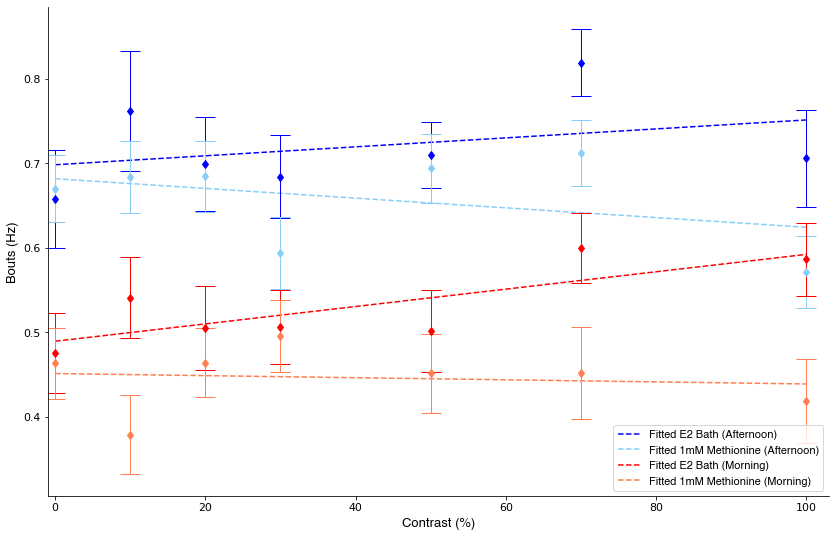

In [135]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

x = [0,10,20,30,50,70,100]

# ax.plot(x,pm_e_bout_hz,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_e_bout_hz_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_bout_hz,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_me_bout_hz_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
     
# ax.plot(x,am_e_bout_hz,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_bout_hz_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_bout_hz,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_bout_hz_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')


ax.errorbar(x,pm_e_bout_hz,yerr=pm_e_bout_hz_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_bout_hz,yerr=pm_me_bout_hz_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

ax.errorbar(x,am_e_bout_hz,yerr=am_e_bout_hz_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_bout_hz,yerr=am_me_bout_hz_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='lower right',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Bouts (Hz)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# ax.set_ylim(0,0.5)
ax.set_xlim(-1,103)
plt.savefig('../../Dissertation/bout_freq_function.png',dpi=400,bbox_inches='tight')
plt.show()

# Interbout Interval OLS and ANOVA

In [136]:
full_fish_list

,bouts_Hz,duration_avg,duration_sem,latency_avg,latency_sem,distance_avg,distance_sem,total_distance,time,medium,contrast
fish_n,,,,,,,,,,,
1,0.466667,0.398571,0.024312,1.857692,0.367417,53.805848,18.367324,753.281874,am,e,1
2,0.033333,0.32,NaN,NaN,NaN,15.474832,NaN,15.474832,am,e,1
3,0.833333,0.414,0.015177,0.780417,0.073429,46.61023,2.788811,1165.255739,am,e,1
4,0.233333,0.468571,0.011218,3.553333,1.129657,50.007648,10.318067,350.053537,am,e,1
5,0.033333,0.34,NaN,NaN,NaN,17.218222,NaN,17.218222,am,e,1
...,...,...,...,...,...,...,...,...,...,...,...
822,0.566667,0.422353,0.038113,1.381875,0.316232,47.190811,8.009851,802.243785,pm,me,100
823,1.000000,0.343,0.021952,0.633103,0.064068,51.759852,5.250618,1552.795557,pm,me,100
824,0.866667,0.403077,0.028462,0.771200,0.112456,70.79847,9.753856,1840.760211,pm,me,100


In [137]:
full_fish_list['latency_avg']=pd.to_numeric(full_fish_list['latency_avg'])

In [138]:
am_fish_list['latency_avg']=pd.to_numeric(am_fish_list['latency_avg'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_53412/91959815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_fish_list['latency_avg']=pd.to_numeric(am_fish_list['latency_avg'])


In [139]:
pm_fish_list['latency_avg']=pd.to_numeric(pm_fish_list['latency_avg'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_53412/3614410718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_fish_list['latency_avg']=pd.to_numeric(pm_fish_list['latency_avg'])


In [140]:
interbout_model = ols(formula='latency_avg ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=full_fish_list).fit()
anova_table_interbout = sm.stats.anova_lm(interbout_model, typ=3)
anova_table_interbout

,sum_sq,df,F,PR(>F)
Intercept,2163.530731,1.0,551.573096,7.549990e-93
"C(medium, Sum)",40.890877,1.0,10.424769,1.294917e-03
"C(time, Sum)",182.812638,1.0,46.606471,1.734208e-11
"C(contrast, Sum)",7.596307,6.0,0.322769,9.252096e-01
"C(medium, Sum):C(time, Sum)",24.397540,1.0,6.219938,1.283613e-02
"C(medium, Sum):C(contrast, Sum)",29.468089,6.0,1.252105,2.774019e-01
"C(time, Sum):C(contrast, Sum)",21.643777,6.0,0.919648,4.799363e-01
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",19.068703,6.0,0.810233,5.620539e-01
Residual,3086.986469,787.0,NaN,NaN


In [141]:
am_interbout_model = ols(formula='latency_avg ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=am_fish_list).fit()
anova_table_interbout_am = sm.stats.anova_lm(am_interbout_model, typ=3)
anova_table_interbout_am

,sum_sq,df,F,PR(>F)
Intercept,1660.469348,1.0,225.109499,1.098895e-39
"C(medium, Sum)",59.182449,1.0,8.023353,4.883621e-03
"C(contrast, Sum)",23.264684,6.0,0.525665,7.888049e-01
"C(medium, Sum):C(contrast, Sum)",43.289564,6.0,0.978126,4.398189e-01
Residual,2596.448458,352.0,NaN,NaN


In [142]:
pm_interbout_model = ols(formula='latency_avg ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=pm_fish_list).fit()
anova_table_interbout_pm = sm.stats.anova_lm(pm_interbout_model, typ=3)
anova_table_interbout_pm

,sum_sq,df,F,PR(>F)
Intercept,595.010452,1.0,527.644220,4.784018e-77
"C(medium, Sum)",1.157535,1.0,1.026481,3.115498e-01
"C(contrast, Sum)",4.521077,6.0,0.668201,6.754379e-01
"C(medium, Sum):C(contrast, Sum)",1.479668,6.0,0.218690,9.707580e-01
Residual,490.538012,435.0,NaN,NaN


In [143]:
pg.welch_anova(data=am_fish_list,dv='latency_avg',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,214.778726,8.125074,0.004791,0.021638


In [144]:
pg.welch_anova(data=pm_fish_list,dv='latency_avg',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,438.080562,1.055136,0.304894,0.002303


# Interbout Intervals Mean & SEM Calculations

In [145]:
am_e_interbout = [am_e_1_fish_list['latency_avg'].mean(),am_e_10_fish_list['latency_avg'].mean(),\
               am_e_20_fish_list['latency_avg'].mean(),am_e_30_fish_list['latency_avg'].mean(),\
               am_e_50_fish_list['latency_avg'].mean(),am_e_70_fish_list['latency_avg'].mean(),\
               am_e_100_fish_list['latency_avg'].mean()]
am_me_interbout = [am_me_1_fish_list['latency_avg'].mean(),am_me_10_fish_list['latency_avg'].mean(),\
               am_me_20_fish_list['latency_avg'].mean(),am_me_30_fish_list['latency_avg'].mean(),\
               am_me_50_fish_list['latency_avg'].mean(),am_me_70_fish_list['latency_avg'].mean(),\
               am_me_100_fish_list['latency_avg'].mean()]
pm_e_interbout = [pm_e_1_fish_list['latency_avg'].mean(),pm_e_10_fish_list['latency_avg'].mean(),\
               pm_e_20_fish_list['latency_avg'].mean(),pm_e_30_fish_list['latency_avg'].mean(),\
               pm_e_50_fish_list['latency_avg'].mean(),pm_e_70_fish_list['latency_avg'].mean(),\
               pm_e_100_fish_list['latency_avg'].mean()]
pm_me_interbout = [pm_me_1_fish_list['latency_avg'].mean(),pm_me_10_fish_list['latency_avg'].mean(),\
               pm_me_20_fish_list['latency_avg'].mean(),pm_me_30_fish_list['latency_avg'].mean(),\
               pm_me_50_fish_list['latency_avg'].mean(),pm_me_70_fish_list['latency_avg'].mean(),\
               pm_me_100_fish_list['latency_avg'].mean()]

In [146]:
am_e_1_interbout_sem = stats.sem(am_e_1_fish_list['latency_avg'],nan_policy='omit')
am_e_10_interbout_sem = stats.sem(am_e_10_fish_list['latency_avg'],nan_policy='omit')
am_e_20_interbout_sem = stats.sem(am_e_20_fish_list['latency_avg'],nan_policy='omit')
am_e_30_interbout_sem = stats.sem(am_e_30_fish_list['latency_avg'],nan_policy='omit')
am_e_50_interbout_sem = stats.sem(am_e_50_fish_list['latency_avg'],nan_policy='omit')
am_e_70_interbout_sem = stats.sem(am_e_70_fish_list['latency_avg'],nan_policy='omit')
am_e_100_interbout_sem = stats.sem(am_e_100_fish_list['latency_avg'],nan_policy='omit')

In [147]:
am_me_1_interbout_sem = stats.sem(am_me_1_fish_list['latency_avg'],nan_policy='omit')
am_me_10_interbout_sem = stats.sem(am_me_10_fish_list['latency_avg'],nan_policy='omit')
am_me_20_interbout_sem = stats.sem(am_me_20_fish_list['latency_avg'],nan_policy='omit')
am_me_30_interbout_sem = stats.sem(am_me_30_fish_list['latency_avg'],nan_policy='omit')
am_me_50_interbout_sem = stats.sem(am_me_50_fish_list['latency_avg'],nan_policy='omit')
am_me_70_interbout_sem = stats.sem(am_me_70_fish_list['latency_avg'],nan_policy='omit')
am_me_100_interbout_sem = stats.sem(am_me_100_fish_list['latency_avg'],nan_policy='omit')

In [148]:
pm_e_1_interbout_sem = stats.sem(pm_e_1_fish_list['latency_avg'],nan_policy='omit')
pm_e_10_interbout_sem = stats.sem(pm_e_10_fish_list['latency_avg'],nan_policy='omit')
pm_e_20_interbout_sem = stats.sem(pm_e_20_fish_list['latency_avg'],nan_policy='omit')
pm_e_30_interbout_sem = stats.sem(pm_e_30_fish_list['latency_avg'],nan_policy='omit')
pm_e_50_interbout_sem = stats.sem(pm_e_50_fish_list['latency_avg'],nan_policy='omit')
pm_e_70_interbout_sem = stats.sem(pm_e_70_fish_list['latency_avg'],nan_policy='omit')
pm_e_100_interbout_sem = stats.sem(pm_e_100_fish_list['latency_avg'],nan_policy='omit')

In [149]:
pm_me_1_interbout_sem = stats.sem(pm_me_1_fish_list['latency_avg'],nan_policy='omit')
pm_me_10_interbout_sem = stats.sem(pm_me_10_fish_list['latency_avg'],nan_policy='omit')
pm_me_20_interbout_sem = stats.sem(pm_me_20_fish_list['latency_avg'],nan_policy='omit')
pm_me_30_interbout_sem = stats.sem(pm_me_30_fish_list['latency_avg'],nan_policy='omit')
pm_me_50_interbout_sem = stats.sem(pm_me_50_fish_list['latency_avg'],nan_policy='omit')
pm_me_70_interbout_sem = stats.sem(pm_me_70_fish_list['latency_avg'],nan_policy='omit')
pm_me_100_interbout_sem = stats.sem(pm_me_100_fish_list['latency_avg'],nan_policy='omit')

In [150]:
am_e_interbout_yerr = [am_e_1_interbout_sem,am_e_10_interbout_sem,am_e_20_interbout_sem,am_e_30_interbout_sem,\
                     am_e_50_interbout_sem,am_e_70_interbout_sem,am_e_100_interbout_sem]
am_me_interbout_yerr = [am_me_1_interbout_sem,am_me_10_interbout_sem,am_me_20_interbout_sem,am_me_30_interbout_sem,\
                      am_me_50_interbout_sem,am_me_70_interbout_sem,am_me_100_interbout_sem]

pm_e_interbout_yerr = [pm_e_1_interbout_sem,pm_e_10_interbout_sem,pm_e_20_interbout_sem,pm_e_30_interbout_sem,\
                     pm_e_50_interbout_sem,pm_e_70_interbout_sem,pm_e_100_interbout_sem]
pm_me_interbout_yerr = [pm_me_1_interbout_sem,pm_me_10_interbout_sem,pm_me_20_interbout_sem,pm_me_30_interbout_sem,\
                      pm_me_50_interbout_sem,pm_me_70_interbout_sem,pm_me_100_interbout_sem]

In [151]:
am_e_interbout_fit = fit_straight_line(am_e_interbout)
am_me_interbout_fit = fit_straight_line(am_me_interbout)
pm_e_interbout_fit = fit_straight_line(pm_e_interbout)
pm_me_interbout_fit = fit_straight_line(pm_me_interbout)

# Interbout Interval Plot

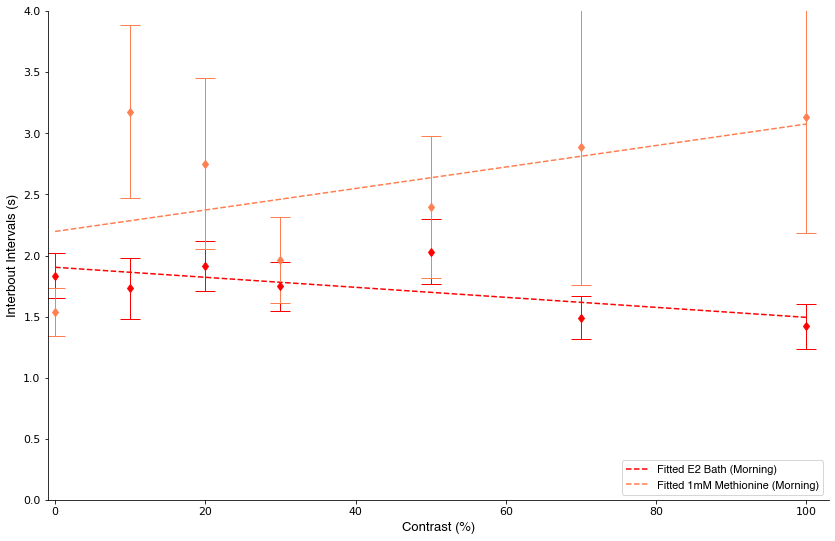

In [152]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

x = [0,10,20,30,50,70,100]

# ax.plot(x,pm_e_interbout,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
# ax.plot(np.linspace(0,100,50),pm_e_interbout_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_interbout,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
# ax.plot(np.linspace(0,100,50),pm_me_interbout_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
     
# ax.plot(x,am_e_interbout,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_interbout_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_interbout,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_interbout_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')


# ax.errorbar(x,pm_e_interbout,yerr=pm_e_interbout_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
# ax.errorbar(x,pm_me_interbout,yerr=pm_me_interbout_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

ax.errorbar(x,am_e_interbout,yerr=am_e_interbout_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_interbout,yerr=am_me_interbout_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='lower right',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Interbout Intervals (s)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.set_ylim(0,4)
ax.set_xlim(-1,103)
# plt.savefig('../../Dissertation/interbout_interval_function.png',dpi=400,bbox_inches='tight')
plt.show()

In [153]:
am_e_100_fish_list['latency_avg'].mean()

1.4218602041591593

In [154]:
am_e_100_fish_list['latency_avg'].var()

0.8285109588632747

In [155]:
am_me_100_fish_list['latency_avg'].mean()

3.1353639262051454

In [156]:
am_me_100_fish_list['latency_avg'].var()

24.504909650905798

(array([3., 8., 4., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1.]),
 array([0.68111111, 0.84056481, 1.00001852, 1.15947222, 1.31892593,
        1.47837963, 1.63783333, 1.79728704, 1.95674074, 2.11619444,
        2.27564815, 2.43510185, 2.59455556, 2.75400926, 2.91346296,
        3.07291667, 3.23237037, 3.39182407, 3.55127778, 3.71073148,
        3.87018519, 4.02963889, 4.18909259, 4.3485463 , 4.508     ]),
 <BarContainer object of 24 artists>)

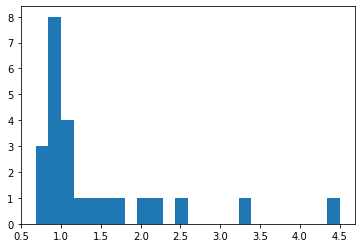

In [157]:
plt.hist(am_e_100_fish_list['latency_avg'],bins=len(am_e_100_fish_list))

(array([13.,  6.,  2.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([ 0.70333333,  1.58987654,  2.47641975,  3.36296296,  4.24950617,
         5.13604938,  6.02259259,  6.9091358 ,  7.79567901,  8.68222222,
         9.56876543, 10.45530864, 11.34185185, 12.22839506, 13.11493827,
        14.00148148, 14.88802469, 15.7745679 , 16.66111111, 17.54765432,
        18.43419753, 19.32074074, 20.20728395, 21.09382716, 21.98037037,
        22.86691358, 23.75345679, 24.64      ]),
 <BarContainer object of 27 artists>)

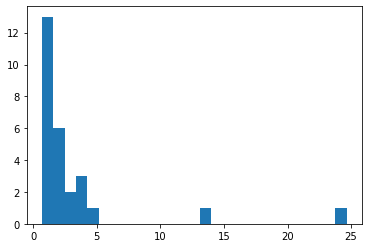

In [158]:
plt.hist(am_me_100_fish_list['latency_avg'],bins=len(am_me_100_fish_list))

{'whiskers': [<matplotlib.lines.Line2D at 0x12ecc8700>,
 'caps': [<matplotlib.lines.Line2D at 0x12ecc8b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x12ecc8430>],
 'medians': [<matplotlib.lines.Line2D at 0x12ecd6160>],
 'fliers': [<matplotlib.lines.Line2D at 0x12ecd6430>],
 'means': []}

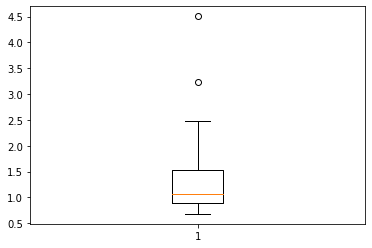

In [159]:
plt.boxplot(am_e_100_fish_list['latency_avg'])

{'whiskers': [<matplotlib.lines.Line2D at 0x12ed39100>,
 'caps': [<matplotlib.lines.Line2D at 0x12ed39580>,
 'boxes': [<matplotlib.lines.Line2D at 0x12ed2adf0>],
 'medians': [<matplotlib.lines.Line2D at 0x12ed39b20>],
 'fliers': [<matplotlib.lines.Line2D at 0x12ed39df0>],
 'means': []}

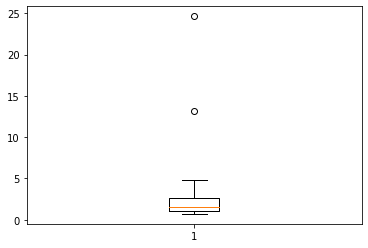

In [160]:
plt.boxplot(am_me_100_fish_list['latency_avg'])

In [161]:
from scipy.stats import poisson
data_poisson = poisson.rvs(mu=3, size=10000)

In [162]:
poisson = np.random.poisson(1, 10000)

In [163]:
stats.kstest(data_poisson, am_e_100_fish_list['latency_avg'])

KstestResult(statistic=0.5862666666666667, pvalue=2.348892060970115e-08)

In [164]:
stats.kstest(data_poisson, am_me_100_fish_list['latency_avg'])

KstestResult(statistic=0.4242296296296296, pvalue=6.523731451196436e-05)

In [165]:
# stats.kstest(am_me_100_fish_list['latency_avg'],stats.poisson(mu=10))
stats.kstest(am_me_100_fish_list['latency_avg'], am_e_100_fish_list['latency_avg'])

KstestResult(statistic=0.3148148148148148, pvalue=0.1267514400523968)

# Relative Freq. vs Turn Angle 

In [166]:
# relative frequency of an event is the number of times the event occurs divided by the total number of trials

In [167]:
np.histogram(am_me_C100_events['delta_theta_rad'])

(array([  3,  12,  53, 138,  81,  41,   5,   2,   2,   2]),
 array([-1.6692330e+00, -1.1134152e+00, -5.5759740e-01, -1.7796000e-03,
         5.5403820e-01,  1.1098560e+00,  1.6656738e+00,  2.2214916e+00,
         2.7773094e+00,  3.3331272e+00,  3.8889450e+00]))

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  4.,  0.,  1.,  2.,  1.,  3.,  8., 12., 68., 21., 22., 13.,
        17., 13., 11.,  4., 10., 13., 12.,  9., 10., 12., 14., 10., 11.,
        13., 10.,  9., 19.,  5.,  4.,  4.,  8.,  5.,  1.,  4.,  4.,  7.,
         4.,  1.,  2.,  4.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.]),
 array([-2.48097  , -2.4294811, -2.3779922, -2.3265033, -2.2750144,
        -2.2235255, -2.1720366, -2.1205477, -2.0690588, -2.0175699,
        -1.966081 , -1.9145921, -1.8631032, -1.8116143, -1.7601254,
        -1.7086365, -1.6571476, -1.6056587, -1.5541698, -1.5026809,
        -1.451192 , -1.3997031, -1.3482142, -1.2967253, -1.2452364,
        -1.1937475, -1.1422586, -1.0907697, -1.0392808, -0.9877919,
        -0.936303 , -0.884

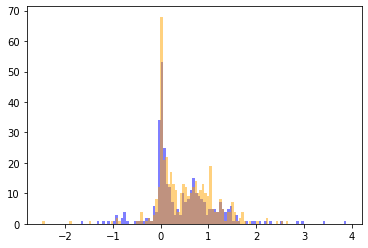

In [168]:
plt.hist(am_me_C100_events['delta_theta_rad'],bins=100,alpha=0.5,color='blue')
plt.hist(am_e_C100_events['delta_theta_rad'],bins=100,alpha=0.5,color='orange')
# plt.xlim(-5,5)

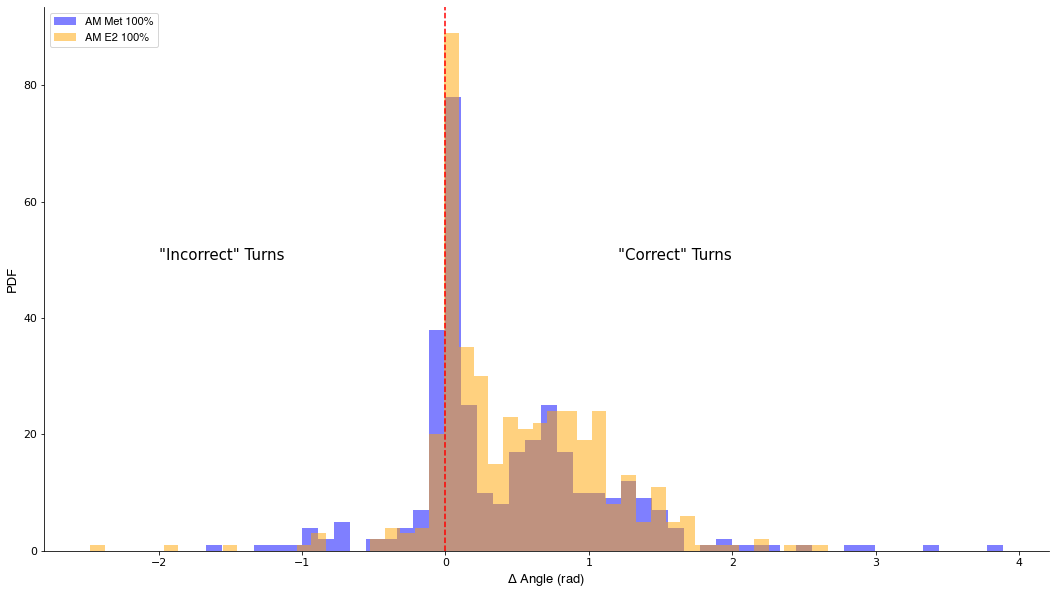

In [170]:
fig, ax = plt.subplots(1,1,figsize=(18,10))

am_me_100_counts, am_me_100_bins = np.histogram(am_me_C100_events['delta_theta_rad'],bins=50)
am_e_100_counts, am_e_100_bins = np.histogram(am_e_C100_events['delta_theta_rad'],bins=50)

plt.hist(am_me_C100_events['delta_theta_rad'],bins=50,alpha=0.5,color='blue',stacked=True,histtype='stepfilled', label='AM Met 100%')
plt.hist(am_e_C100_events['delta_theta_rad'],bins=50,alpha=0.5,color='orange',stacked=True,histtype='stepfilled', label='AM E2 100%')

# ax.plot(am_me_100_bins[1:], am_me_100_counts,label='AM Met 100%',color='blue')
# ax.plot(am_e_100_bins[1:], am_e_100_counts, label='AM E2 100%',color='orange')
# ax.plot(am_e_100_bins[:-1], am_e_100_counts/len(am_e_C100_events), label='AM E2 100%',color='orange')
plt.axvline(x=0,ls='--', color='r')
ax.text(-2, 50, '"Incorrect" Turns',fontsize=15)
ax.text(1.2, 50, '"Correct" Turns',fontsize=15)

plt.xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
plt.ylabel('PDF',name='Helvetica',fontsize=13)

font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font,fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.show()

In [171]:
stats.kstest(am_me_C100_events['delta_theta_rad'],am_e_C100_events['delta_theta_rad'])

KstestResult(statistic=0.11677082022676118, pvalue=0.010661338031343255)